In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os


In [15]:
#importing the data back into the notebook
df=pd.read_csv(r'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Input_files\title_transactions-06-29-2021.csv.gz', compression='gzip', index_col=0)

# Feature Engineering
# Changing data type of 'transaction_date' to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Feature Engineering "m/y" column
df['m/y'] = df['transaction_date'].dt.strftime("%m-%Y")

# Set transaction_date as the index of df
df.set_index('transaction_date', inplace=True)

# Dropping columns that are for Governmental Use
drop_cols = ['electric_vehicle_fee_paid',
             'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility',
             'meets_2019_hb_2042_electric_range_requirement', 
             'meets_2019_hb_2042_sale_date_requirement', 
             'meets_2019_hb_2042_sale_price_value_requirement', 
             'transportation_electrification_fee_paid', 
             'hybrid_vehicle_electrification_fee_paid', 'legislative_district', 
             'non_clean_alternative_fuel']
df.drop(drop_cols, axis=1, inplace=True)

# Remove columns that contain repetitive or duplicate information 
drop_cols = ['transaction_year', 'base_msrp', 'date_of_vehicle_sale']
df.drop(drop_cols, axis=1, inplace=True)

#filtering out registration information to keep vehicle purchase information
df=df[(df['transaction_type']=='Original Title') | 
      (df['transaction_type']=='Transfer Title')]

#Handling duplicates
df.drop_duplicates(inplace=True)

# Duplicates by Date/ID/County
#df[df.duplicated(subset=['m/y', 'dol_vehicle_id', 'county'], keep=False)].sort_values('dol_vehicle_id')
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id', 'county'], keep='last', inplace=True)

# Duplicates by Date/ID
#df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], keep=False)].sort_values('dol_vehicle_id')
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id'], keep='last', inplace=True)

# Checking for and Addressing Null Values
#dropping null values
df.dropna(subset=['county'], inplace=True)

#Vehicles owned by non-Washington residents will be excluded from the data analysis
df=df[df['state_of_residence']=='WA']

#Try to fill NA values
#filling null values
df['city'].fillna('Unknown', inplace=True)
df['zip'].fillna('Unknown', inplace=True)

# Data Standardization
#Format the model names we can use map() method. ('Panamera' and 'PANAMERA')
df['model']=df['model'].map(lambda x: x.title())
df[df['model']=='Sonata Plug-In Hybrid']['electric_vehicle_type'].unique()
df[df['model']=='Prius Plug-In']['electric_vehicle_type'].unique()

df['model'].replace(['Niro Electric', 'Niro Plug-In Hybrid'], 'Niro', 
                    inplace=True)
df['model'].replace(['Prius Plug-In', 'Prius Plug-In Hybrid'], 'Prius', 
                    inplace=True)
df['model'].replace('Kona Electric', 'Kona', inplace=True)
df['model'].replace('Optima Plug-In Hybrid', 'Optima', inplace=True)
df['model'].replace('Sonata Plug-In Hybrid', 'Sonata', inplace=True)
df['model'].replace('Xc60 Awd Phev', 'Xc60 Awd', inplace=True)
df['model'].replace('Xc90 Awd Phev', 'Xc90 Awd', inplace=True)

#Strore df in another variable
data = df

#We can slice out the new car purchases for each county and parse the information into a dictionary.
county_dict = {}
for county in list(data['county'].unique()):
    county_dict[county] = data[
        (data['county']==county)&
        (data['transaction_type']=='Original Title')
    ].resample('M').size().cumsum()

#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)

# Electric Vehicles on the Road in Washington State Over Time
#summing each row to get monthly statewide total 
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
df_cumsum = df_cumsum.reset_index()

# Electric Vehicles on the Road Over Time by County
top_ten_counties = data['county'].value_counts().head(10).index.tolist()

#filtering out counties to keep top 10
df_cumsum = df_cumsum.loc[:, ['transaction_date', *top_ten_counties]]

#Strore df in another variable
df_cumsum_1 = df_cumsum

df_cumsum_1 = df_cumsum_1.set_index('transaction_date').resample('M').asfreq()
#resample('M').asfreq() is used to resample the DataFrame df_cumsum at a monthly frequency.

def separate_data_by_county(county, data):
    """Function separates the given dataframe by county and returns the 
    separated dataframe.
    -------------------------------
    Arguments:
    county: str
    Name of county that will be separated from the dataframe. 
    
    df: class: pandas.DataFrame
    Dataframe that contains data for all counties. The specified county will 
    be separated from this DataFrame. 
    """
    
    df_county = pd.DataFrame(data.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county


#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_ten_counties:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum_1)


In [16]:


# Evaluation of Models

def evaluate_model(model, county):
    """Function returns the model summary and diagnostics information to aid 
    the evaluation of the given model's performance.
    -------------------------------
    Arguments:
    model: SARIMAX or ARIMA model object
    Model variable to evaluate (Time series models for both pmdarima and 
    statsmodels are supported. 
    """
    print('evaluate_model with Forecasts for Test Data', county ,'\n')
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();


# Creating a Function for train_test_split & plotting

def train_test_split_ts (data, train_size, test_size):
    
    """Function splits a given DataFrame into two sets based on the given 
    train and test sizes so that the data can be used for validation.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame
    The base dataframe that will be getting split.
    
    train_size: float
    The size of the desired training set (for example: 0.80)
    
    test_size: float
    The size of the desired training set (for example: 0.20)
    """
    
    train_end_idx = int(round(len(data)*train_size,0))
    train_set = data.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = data.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set


# Additionally, to visualize these splits we will need a plotting function.
def plot_train_test_split(train_data, test_data, county):
    
    """Function plots the training and testing data for visual inspection.
    -------------------------------
    Arguments:
    train_data: pandas.Series
    The training set of data to be plotted.
    
    test_data: pandas.Series
    The test set of data to be plotted.
    
    county: str
    Name of the county that the training and testing data belongs to. This 
    string is used to set the title of the axes.
    """
    
    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();


# Creating a Function for Getting Forecasts
def get_forecast(model, train_data, test_data, plot=True):
    
    """Function gets forecasted values from a given model and plots them for 
    visual inspection. The length of the forecasts are dependent on the length 
    of the test data. The forecasted values are returned in a DataFrame format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model that the forecast is to be received from. 
    
    train_data: pandas.Series
    The training set of data used in training the model.
    
    test_data: pandas.Series
    The testing set of data used for validating the model.
    
    plot: bool, default=True
    Option to plot the forecasted values along with observed values 
    (train_data and test_data).
    """
    
    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index, 
                         y='Forecasts', color='blue', ax=ax, 
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax, 
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index, 
                            y1=forecast_df['Lower Confidence Interval'], 
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.legend(loc=2)
            plt.show();
    return forecast_df


# Defining a Function for Getting Predictions for Future
def get_prediction(model, data, test_data, county_name, plot=True):
    
    """Function gets predicted values from a given model and plots them for 
    visual inspection. The length of the predictions are dependent on the 
    length of the test data. The forecasted values are returned in a DataFrame 
    format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model to be used for making predictions.
    
    df: pandas.DataFrame
    DataFrame that contains all observed data.
    
    test_data: pandas.Series
    The testing set of data used for validating the model (dictates the length
    of predictions).
    
    plot: bool, default=True
    Option to plot the predicted values along with observed values.
    """
    
    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval', 
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=data, ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index, 
                         y='Predictions', color='orange', ax=ax, 
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index, 
                            y1=prediction_df['Lower Confidence Interval'], 
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3, 
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

Seasonality Check for :- King


<Figure size 1200x1000 with 0 Axes>

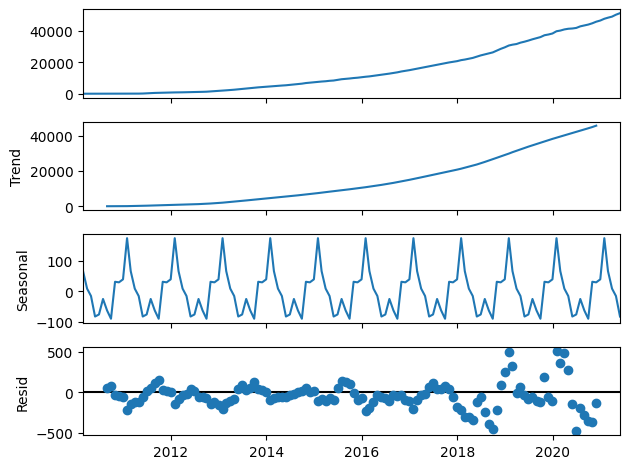

splitting dataset into train and test sets for validation 

plotting the split :- King


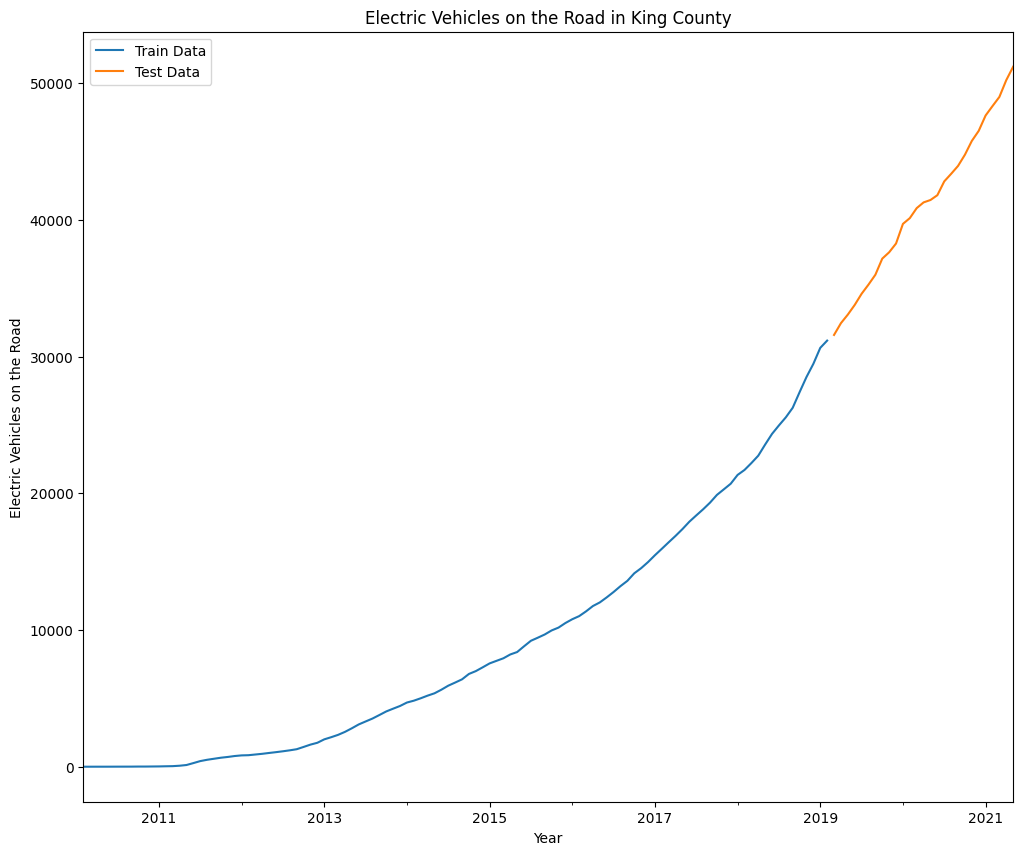

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data King 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -567.043
Date:                            Mon, 03 Jul 2023   AIC                           1138.087
Time:                                    18:10:34   BIC                           1143.195
Sample:                                02-28-2010   HQIC                          1140.151
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8305      0.042     20.002      0.000       0.749       0.912
sigma2      8954.2159    822.909     10.881      0.000    7341.344    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                42.89
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               7.52   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

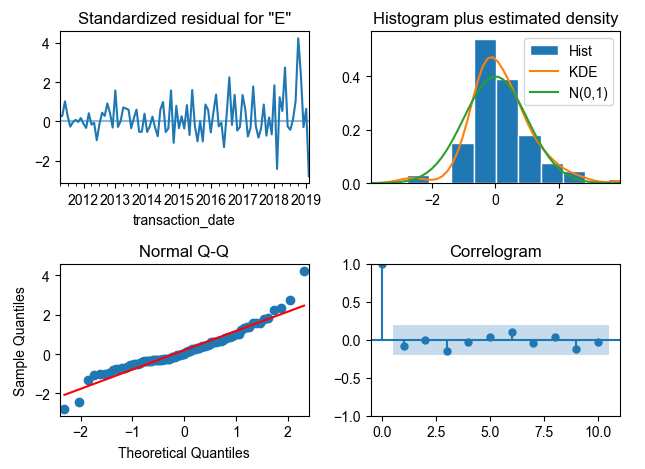

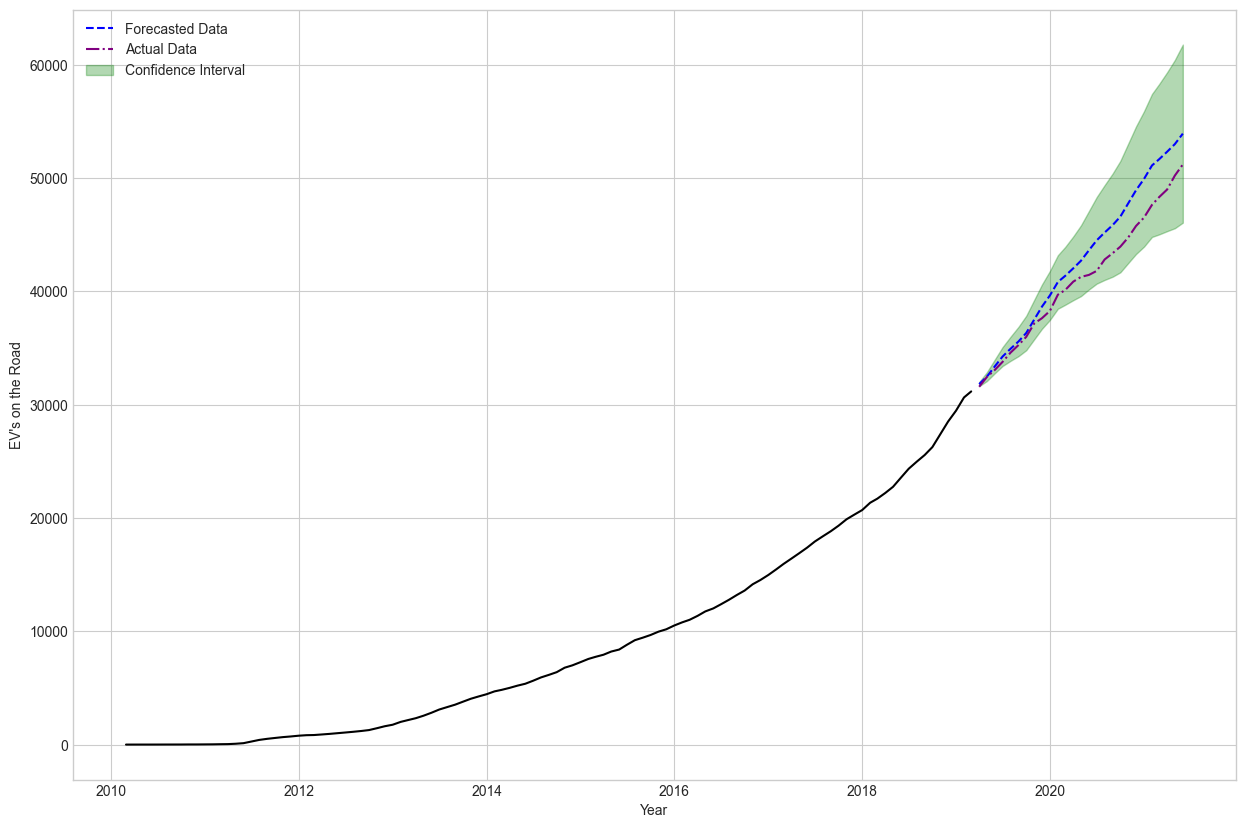

Future Predictions 

evaluate_model with Forecasts for Test Data King 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -818.139
Date:                            Mon, 03 Jul 2023   AIC                           1640.277
Time:                                    18:10:35   BIC                           1645.885
Sample:                                02-28-2010   HQIC                          1642.555
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4919      0.062      7.989      0.000       0.371       0.613
sigma2      3.911e+04   2910.227     13.440      0.000    3.34e+04    4.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):               108.03
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              26.48   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



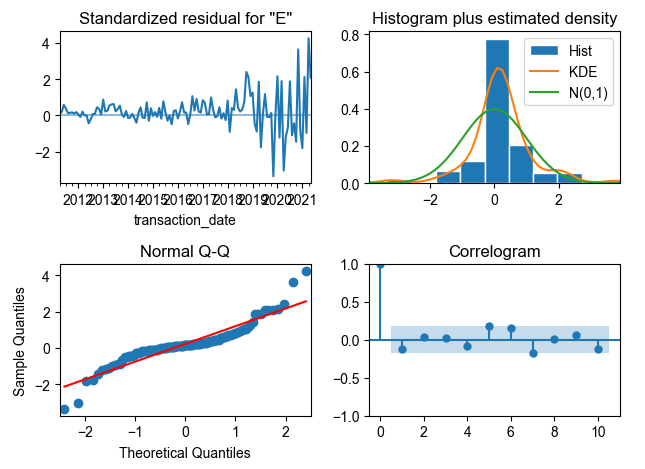

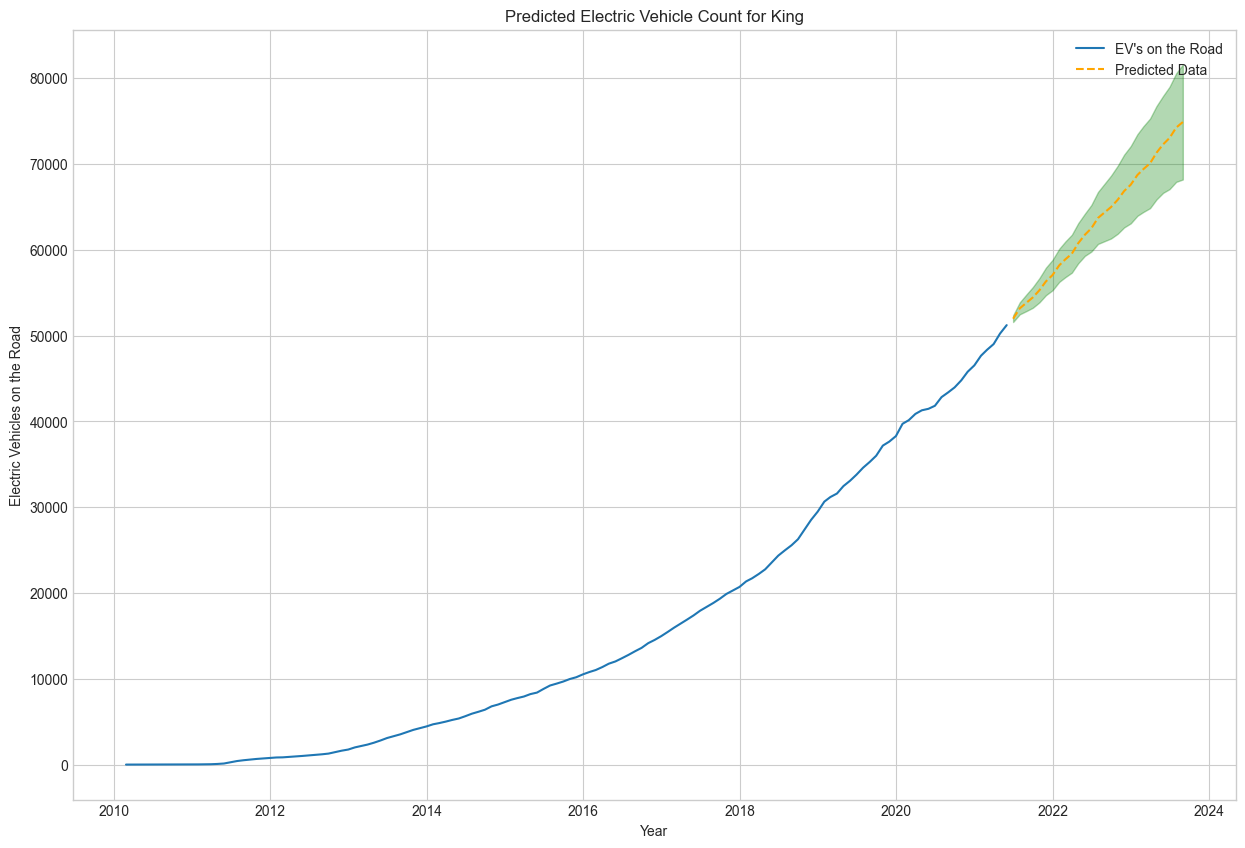

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\King_Prediction.csv'
Seasonality Check for :- Snohomish


<Figure size 1200x1000 with 0 Axes>

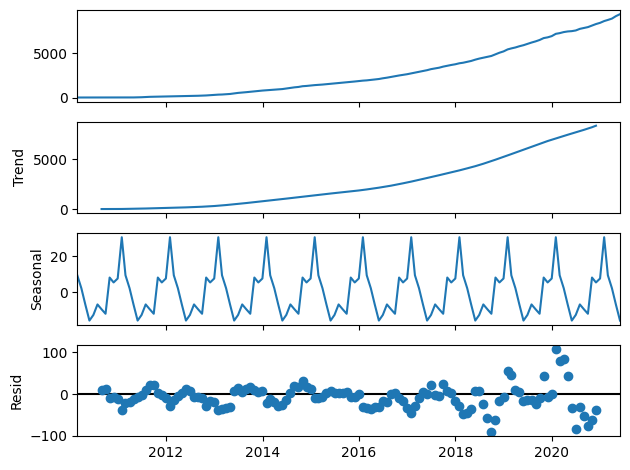

splitting dataset into train and test sets for validation 

plotting the split :- Snohomish


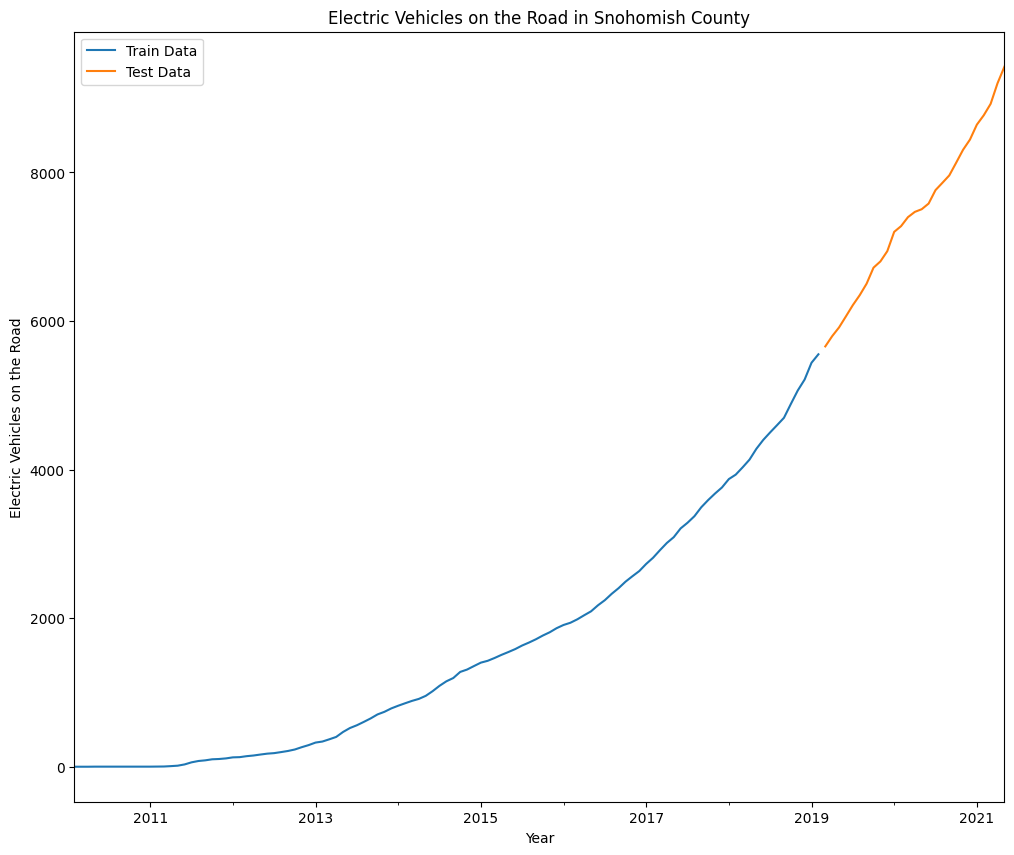

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Snohomish 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -429.165
Date:                            Mon, 03 Jul 2023   AIC                            862.330
Time:                                    18:11:25   BIC                            867.438
Sample:                                02-28-2010   HQIC                           864.394
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6949      0.064     10.930      0.000       0.570       0.820
sigma2       491.3607     38.720     12.690      0.000     415.471     567.250
===================================================================================
Ljung-Box (L1) (Q):                   6.85   Jarque-Bera (JB):                94.83
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               7.36   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

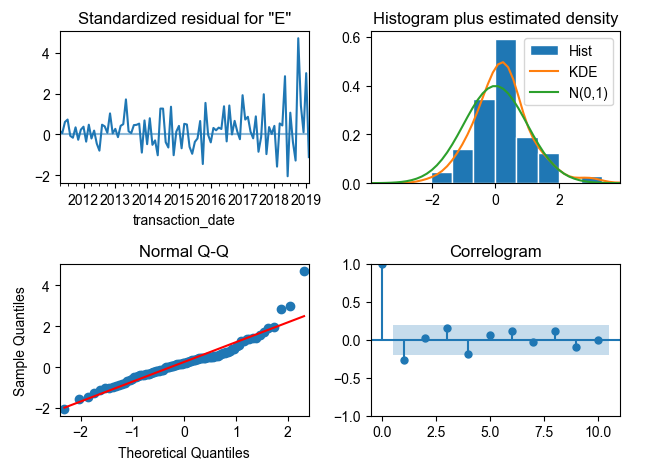

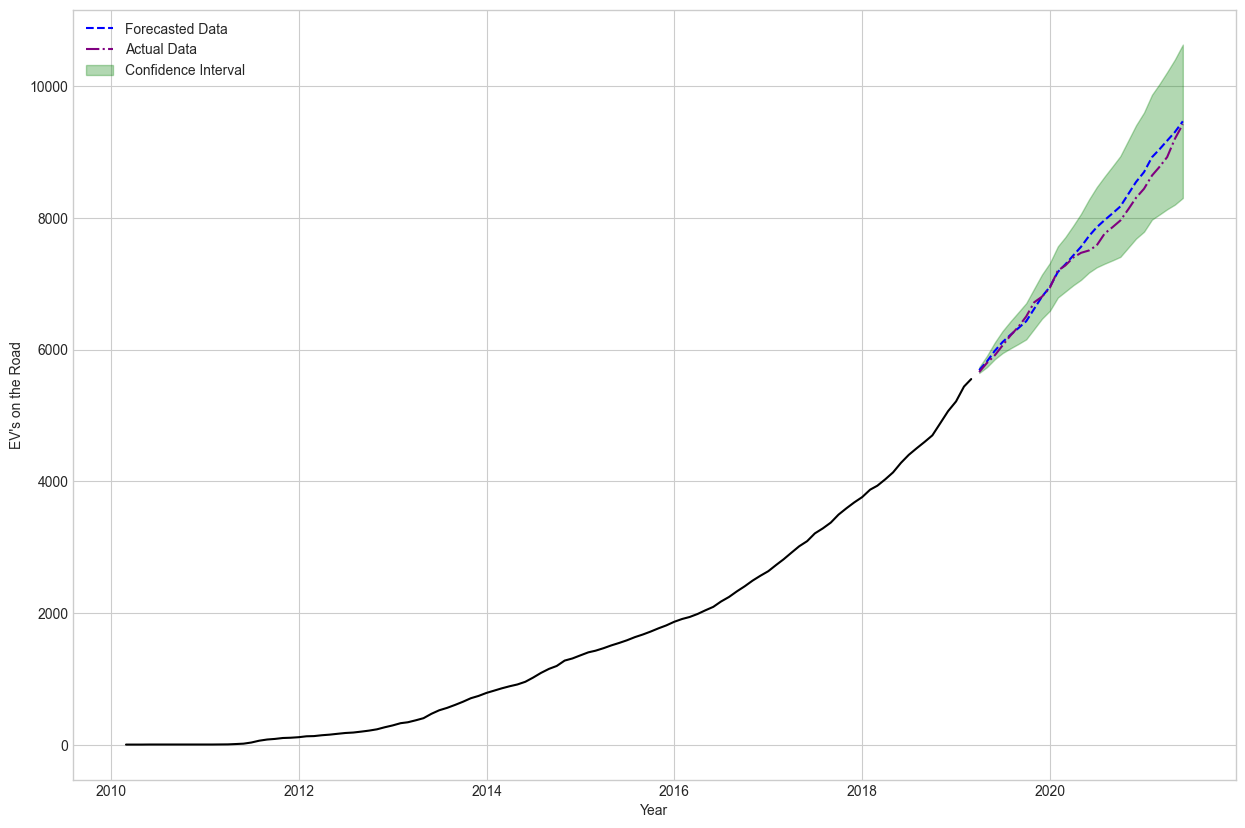

Future Predictions 

evaluate_model with Forecasts for Test Data Snohomish 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -611.312
Date:                            Mon, 03 Jul 2023   AIC                           1226.625
Time:                                    18:11:27   BIC                           1232.233
Sample:                                02-28-2010   HQIC                          1228.902
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5864      0.062      9.450      0.000       0.465       0.708
sigma2      1317.6914     83.861     15.713      0.000    1153.326    1482.057
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):               195.10
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):              17.74   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



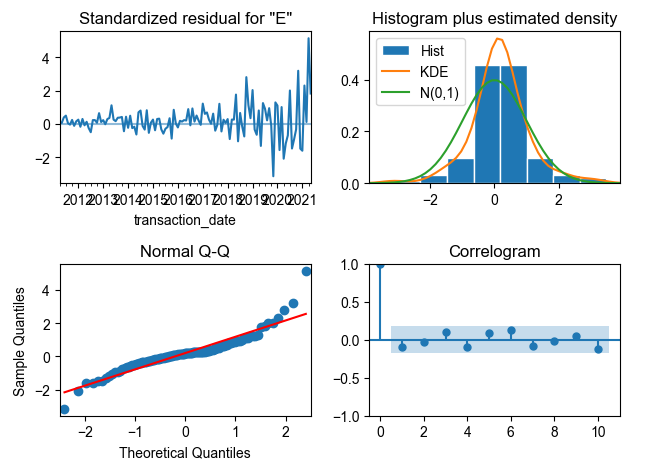

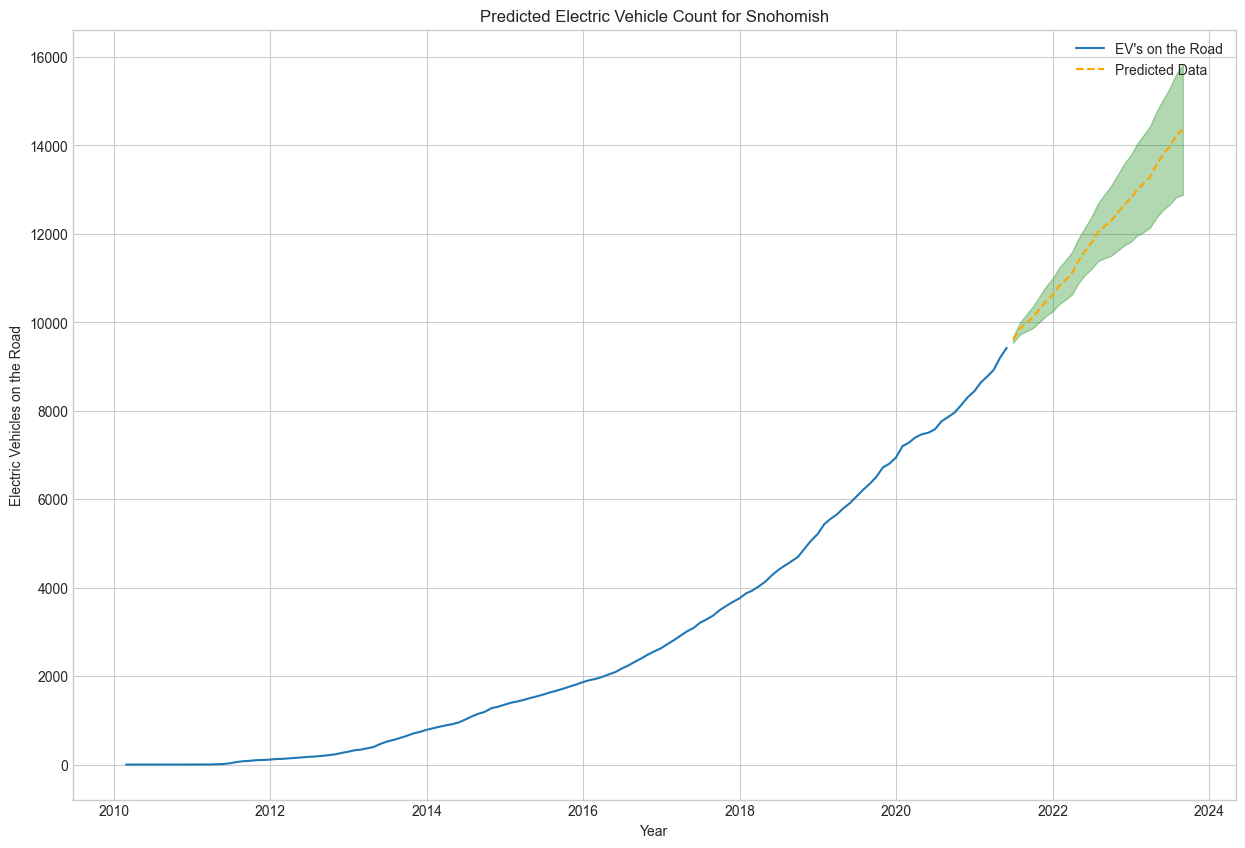

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Snohomish_Prediction.csv'
Seasonality Check for :- Pierce


<Figure size 1200x1000 with 0 Axes>

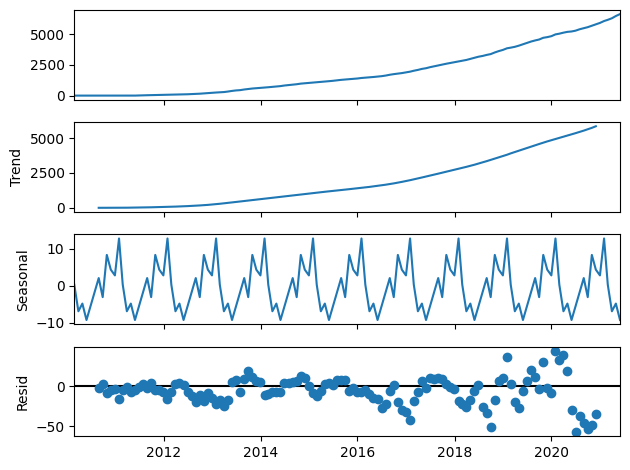

splitting dataset into train and test sets for validation 

plotting the split :- Pierce


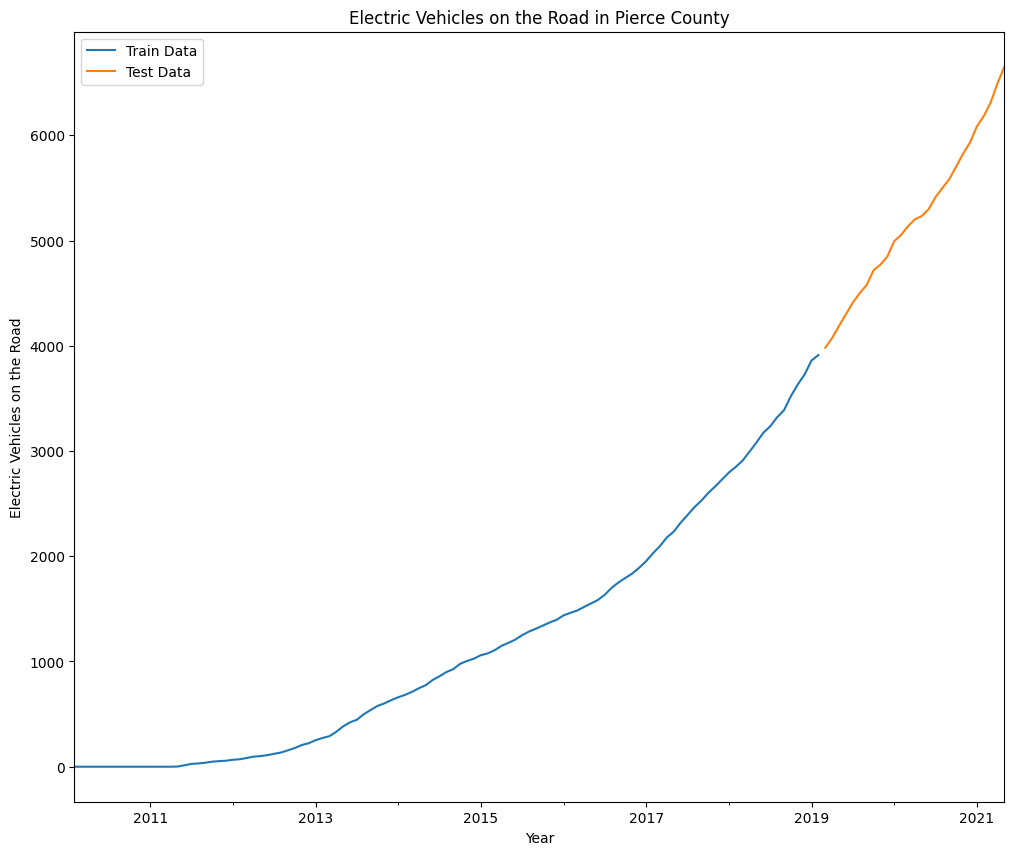

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Pierce 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -397.383
Date:                            Mon, 03 Jul 2023   AIC                            798.766
Time:                                    18:11:54   BIC                            803.874
Sample:                                02-28-2010   HQIC                           800.830
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6426      0.063     10.258      0.000       0.520       0.765
sigma2       251.6602     25.594      9.833      0.000     201.498     301.823
===================================================================================
Ljung-Box (L1) (Q):                   4.89   Jarque-Bera (JB):                18.06
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               3.88   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

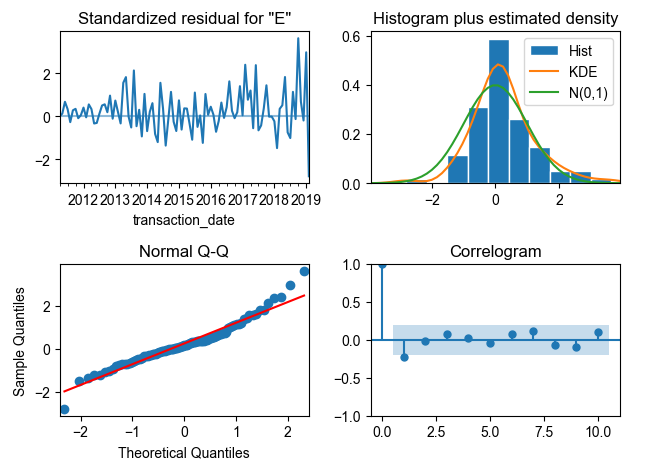

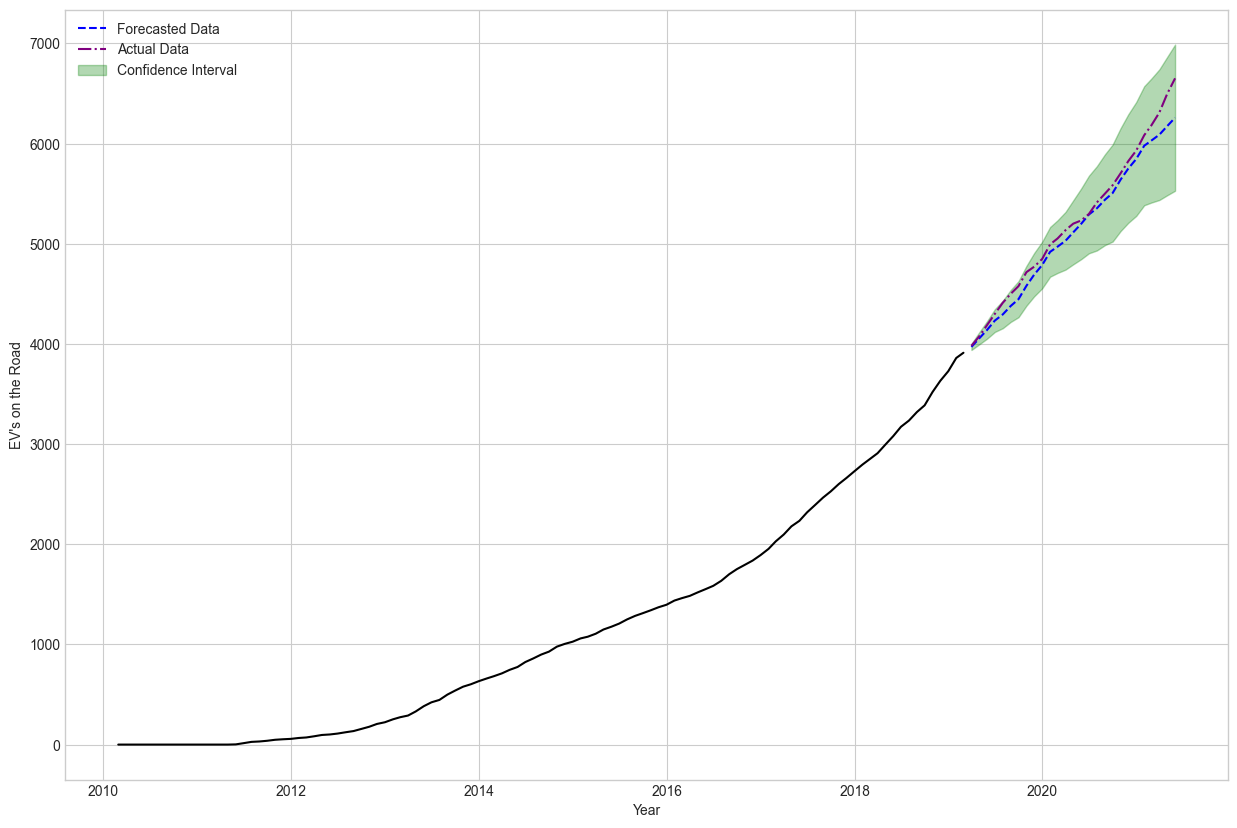

Future Predictions 

evaluate_model with Forecasts for Test Data Pierce 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -548.847
Date:                            Mon, 03 Jul 2023   AIC                           1101.695
Time:                                    18:11:54   BIC                           1107.303
Sample:                                02-28-2010   HQIC                          1103.973
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6979      0.057     12.321      0.000       0.587       0.809
sigma2       473.2495     37.803     12.519      0.000     399.157     547.342
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):                63.19
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               7.15   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



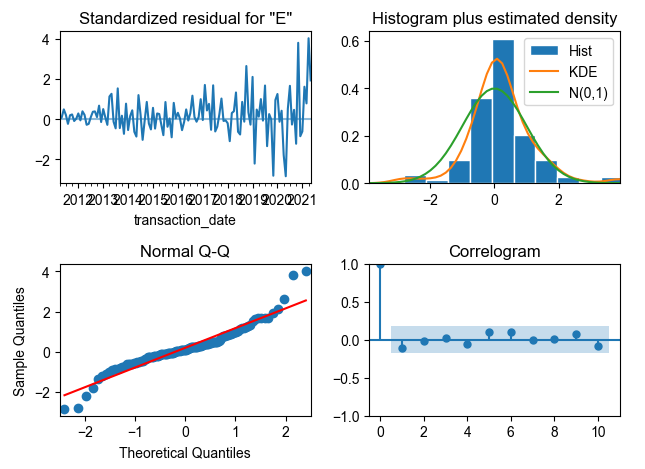

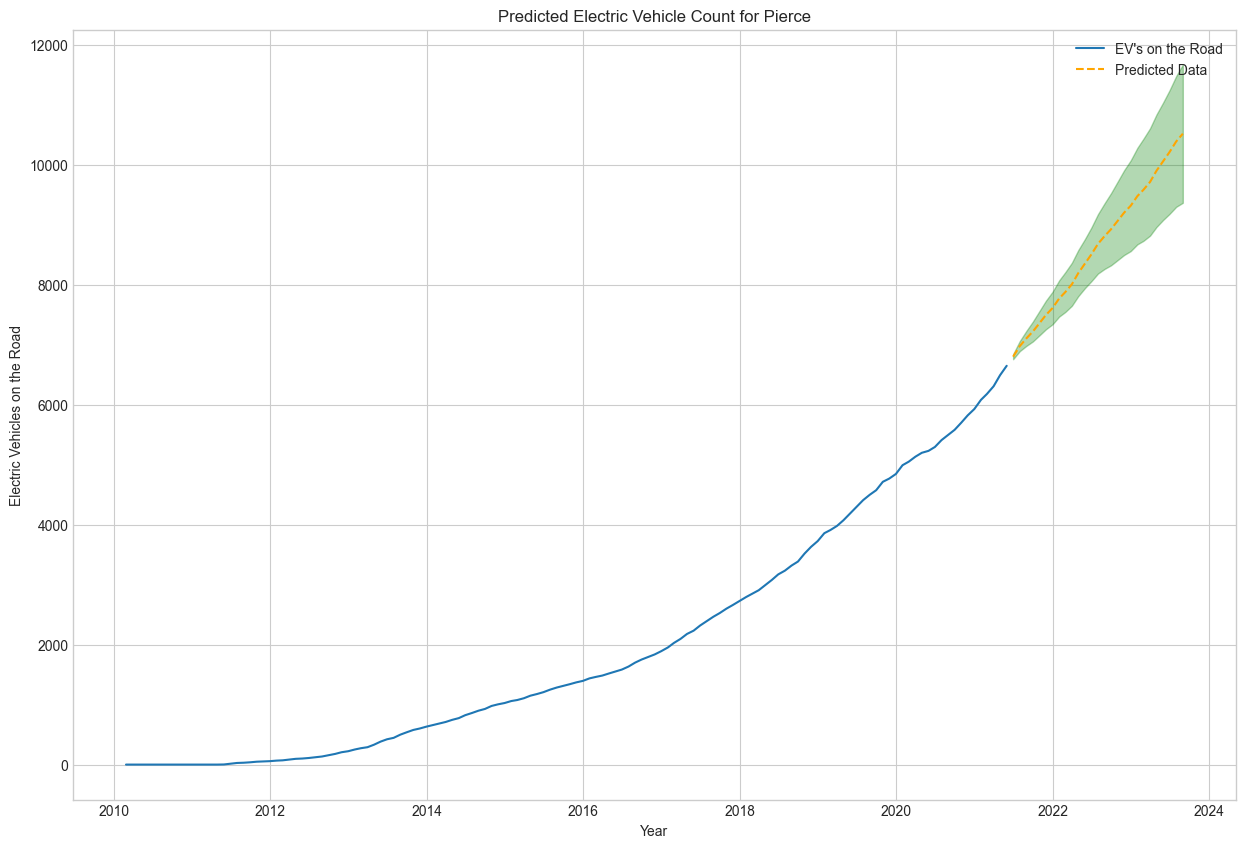

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Pierce_Prediction.csv'
Seasonality Check for :- Clark


<Figure size 1200x1000 with 0 Axes>

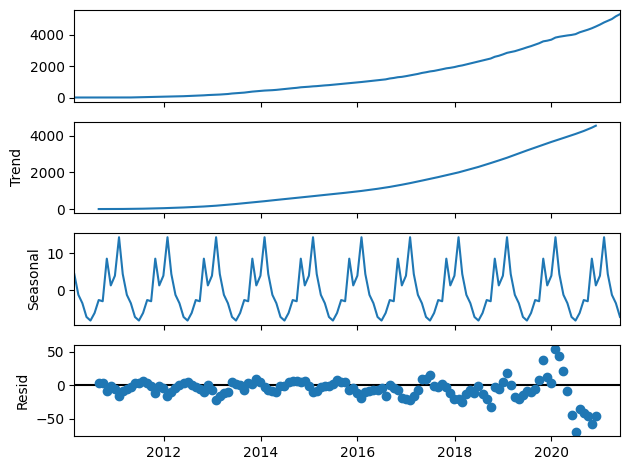

splitting dataset into train and test sets for validation 

plotting the split :- Clark


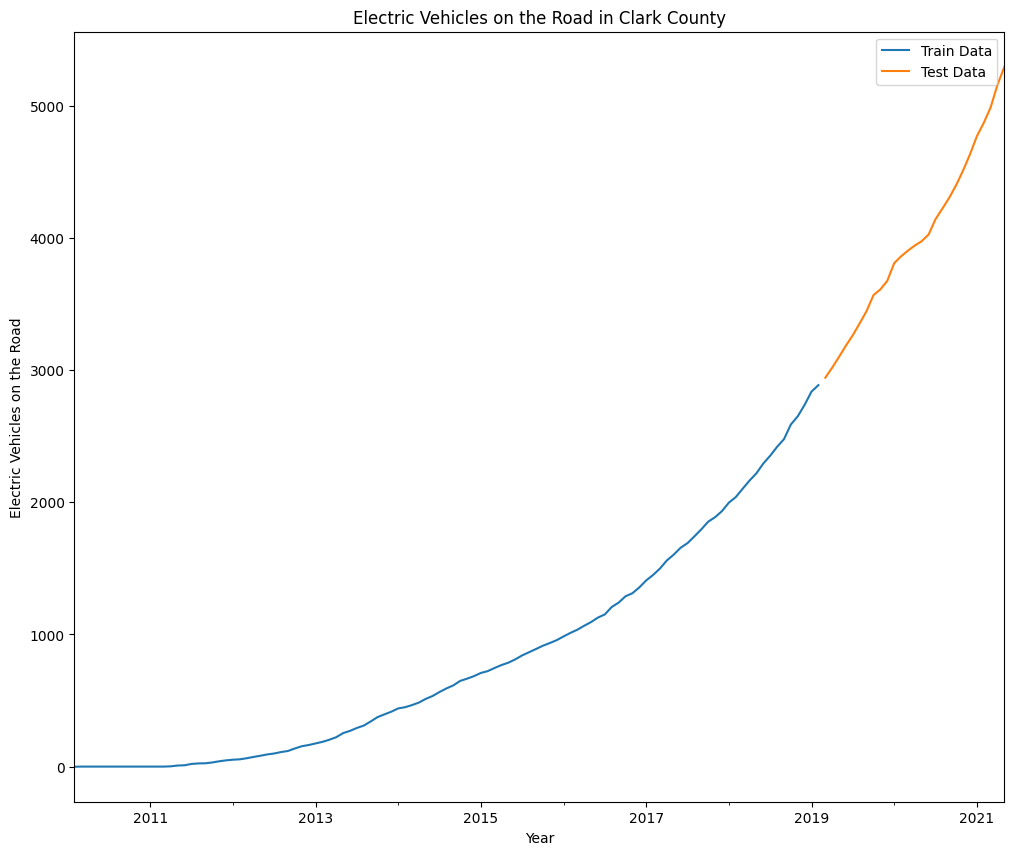

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Clark 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -359.425
Date:                            Mon, 03 Jul 2023   AIC                            722.850
Time:                                    18:12:11   BIC                            727.958
Sample:                                02-28-2010   HQIC                           724.914
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6445      0.082      7.861      0.000       0.484       0.805
sigma2       113.1789      9.098     12.440      0.000      95.348     131.010
===================================================================================
Ljung-Box (L1) (Q):                  17.56   Jarque-Bera (JB):                92.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.88   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

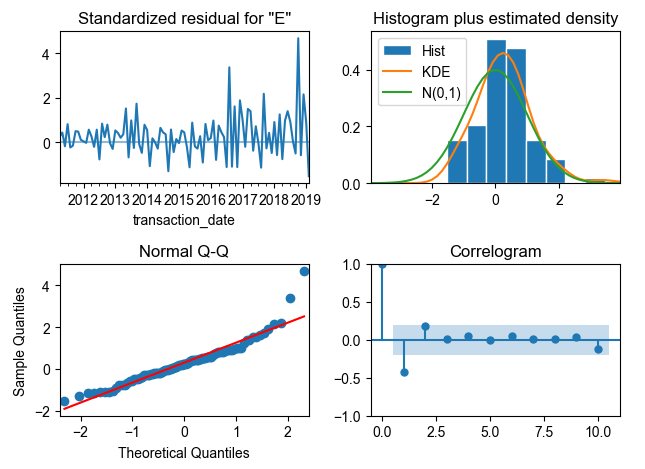

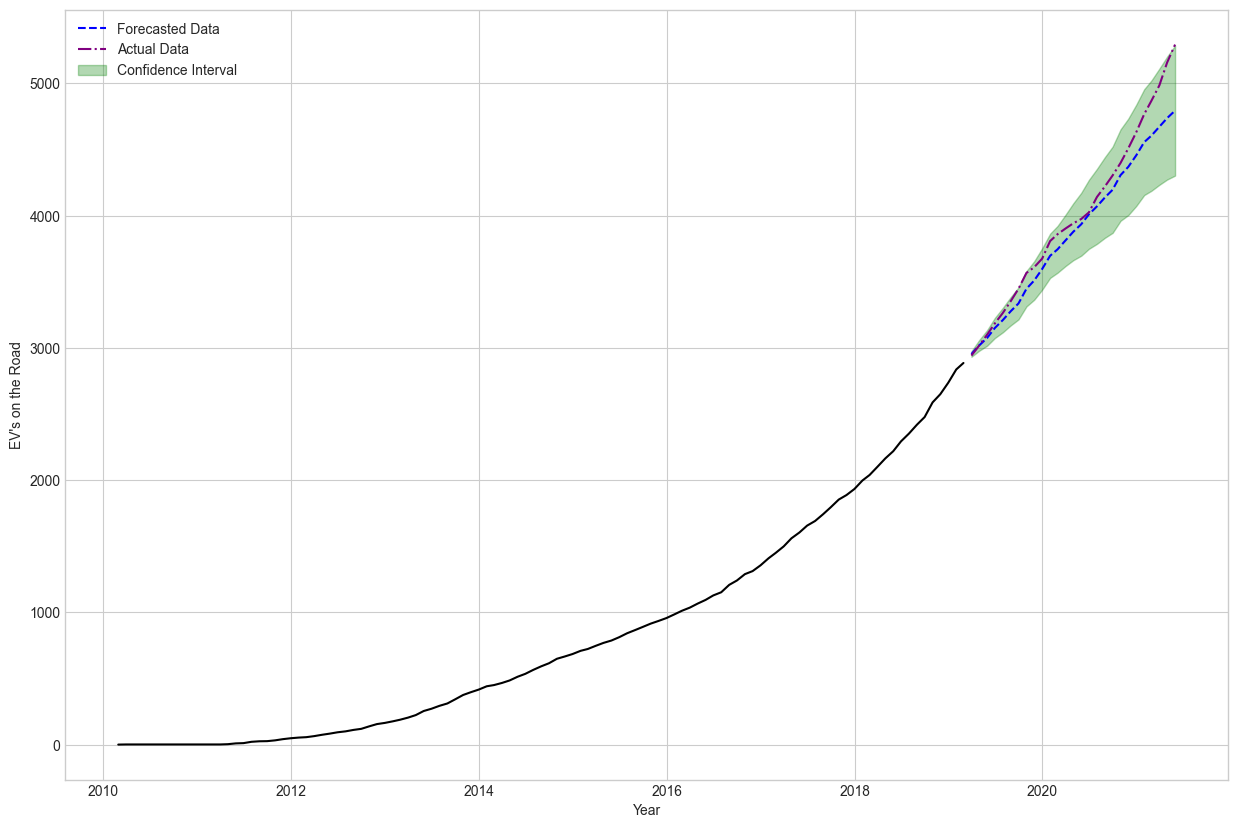

Future Predictions 

evaluate_model with Forecasts for Test Data Clark 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -529.168
Date:                            Mon, 03 Jul 2023   AIC                           1062.336
Time:                                    18:12:12   BIC                           1067.944
Sample:                                02-28-2010   HQIC                          1064.613
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7174      0.044     16.205      0.000       0.631       0.804
sigma2       342.7512     21.549     15.905      0.000     300.515     384.987
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):               217.86
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):              20.77   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



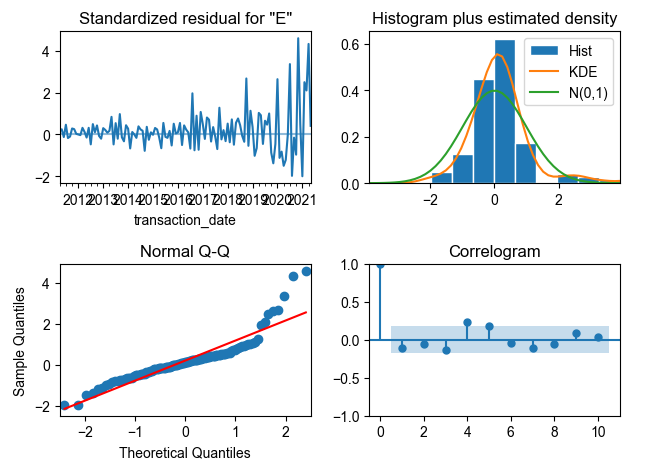

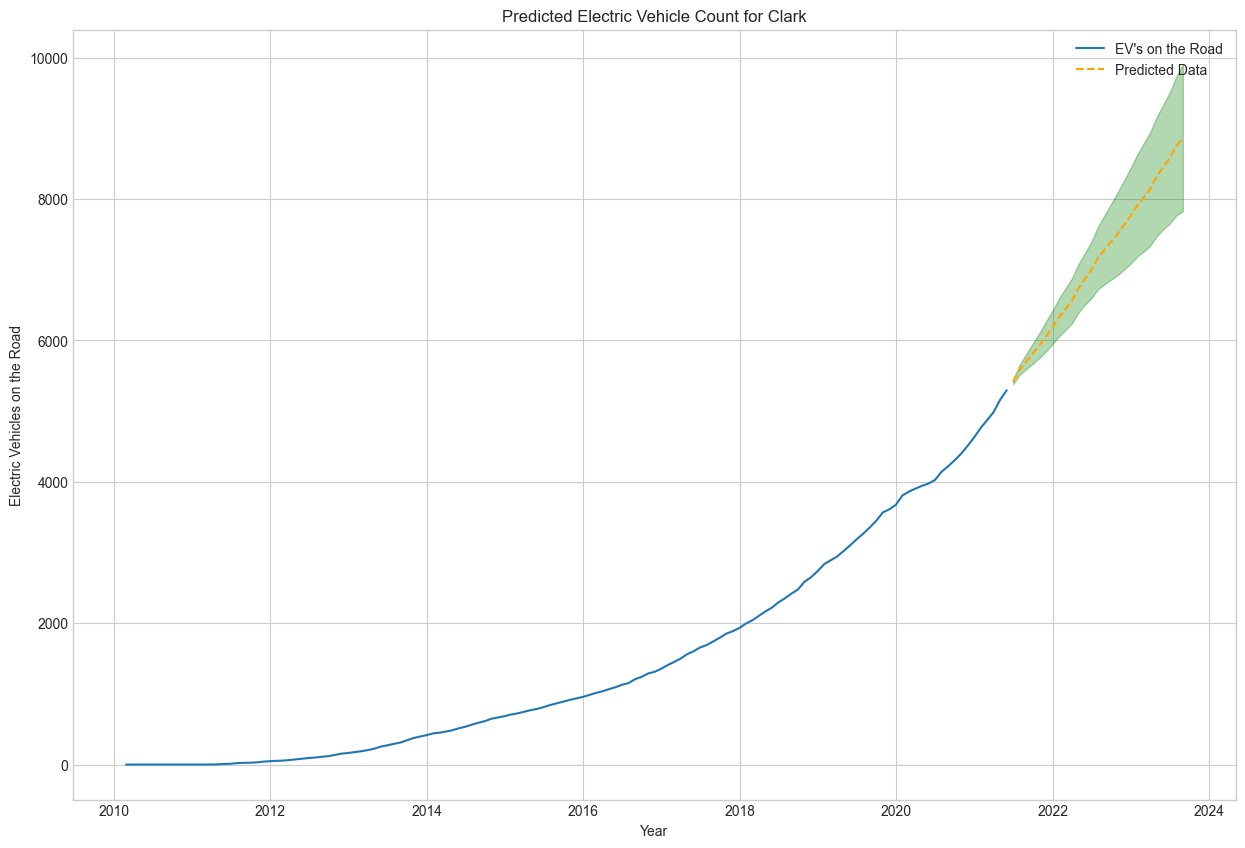

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Clark_Prediction.csv'
Seasonality Check for :- Thurston


<Figure size 1200x1000 with 0 Axes>

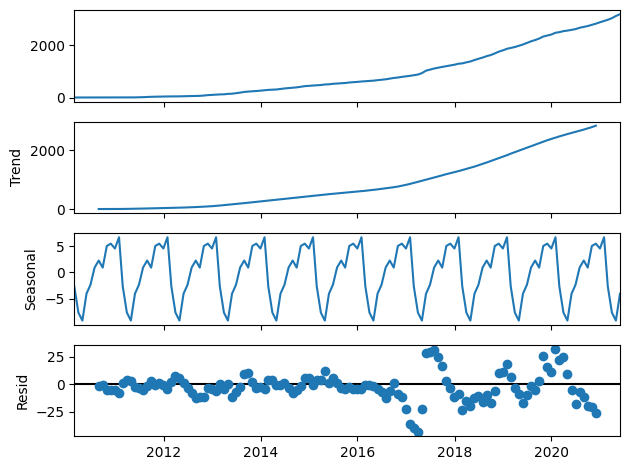

splitting dataset into train and test sets for validation 

plotting the split :- Thurston


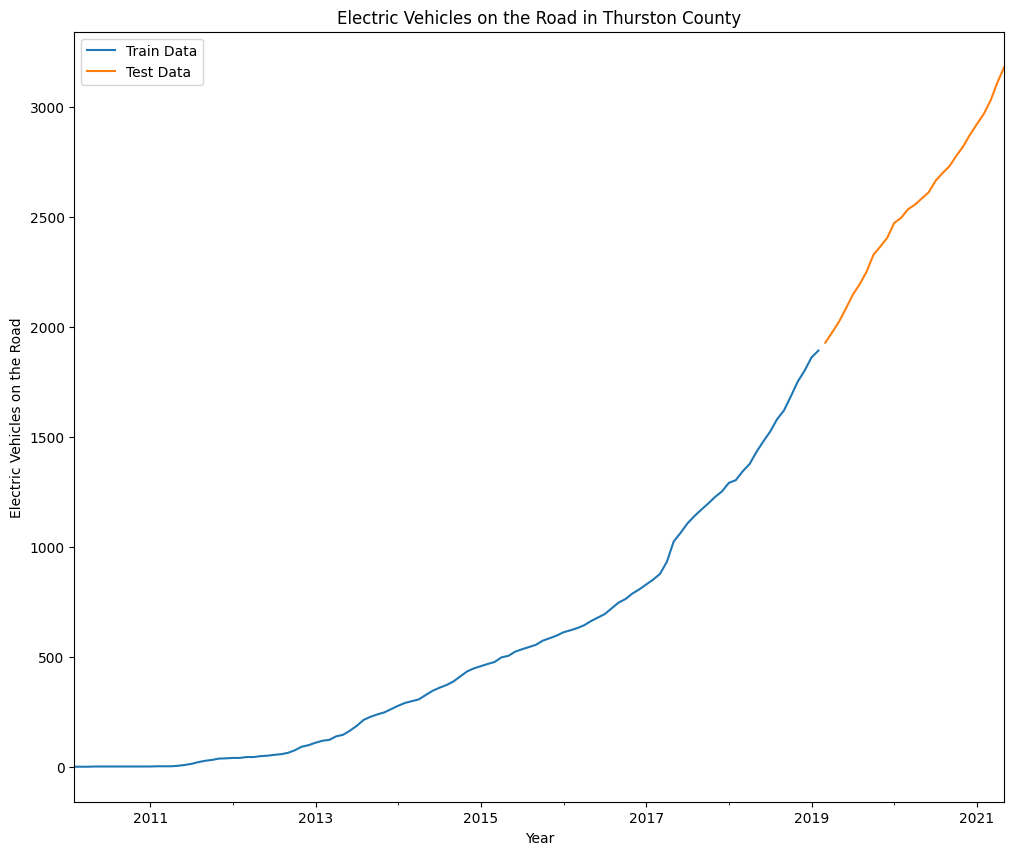

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Thurston 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -372.009
Date:                            Mon, 03 Jul 2023   AIC                            748.017
Time:                                    18:12:22   BIC                            753.125
Sample:                                02-28-2010   HQIC                           750.081
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5914      0.050     11.736      0.000       0.493       0.690
sigma2       147.5081     15.234      9.683      0.000     117.650     177.366
===================================================================================
Ljung-Box (L1) (Q):                   3.04   Jarque-Bera (JB):                27.59
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               8.68   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

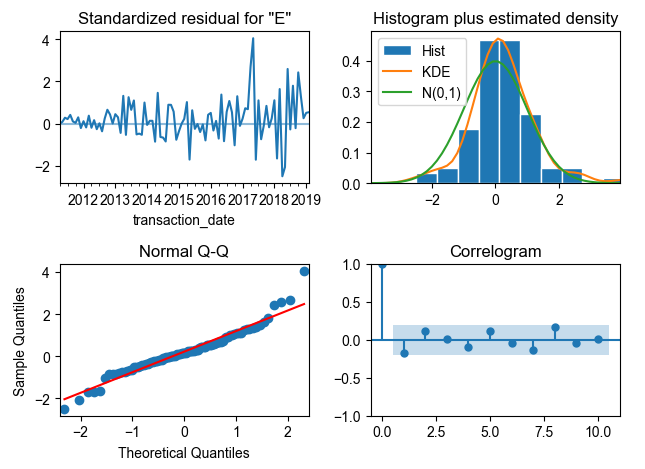

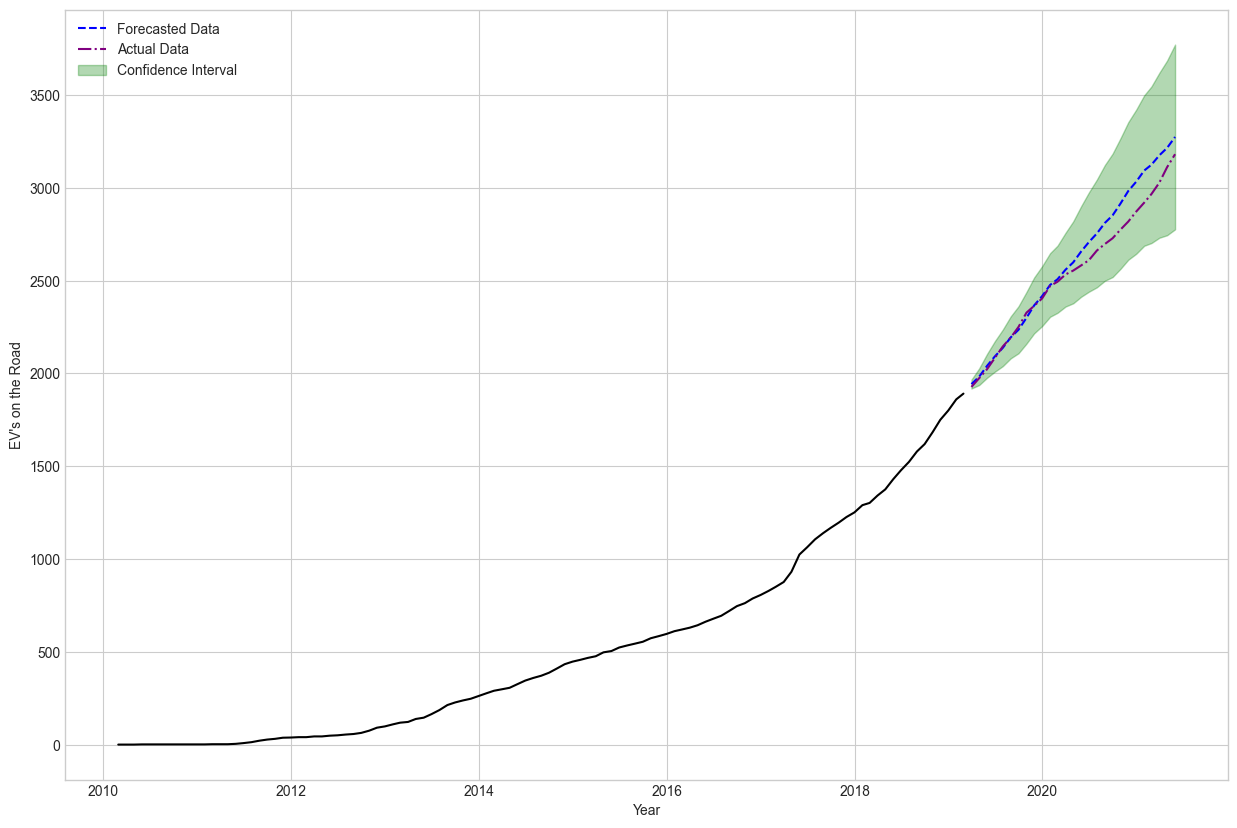

Future Predictions 

evaluate_model with Forecasts for Test Data Thurston 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -496.794
Date:                            Mon, 03 Jul 2023   AIC                            997.588
Time:                                    18:12:23   BIC                           1003.196
Sample:                                02-28-2010   HQIC                           999.866
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5581      0.059      9.492      0.000       0.443       0.673
sigma2       201.6001     20.088     10.036      0.000     162.229     240.971
===================================================================================
Ljung-Box (L1) (Q):                   2.24   Jarque-Bera (JB):                15.71
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               7.92   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



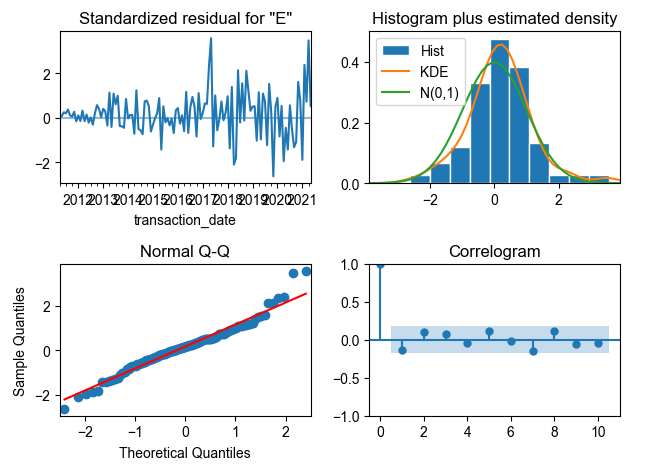

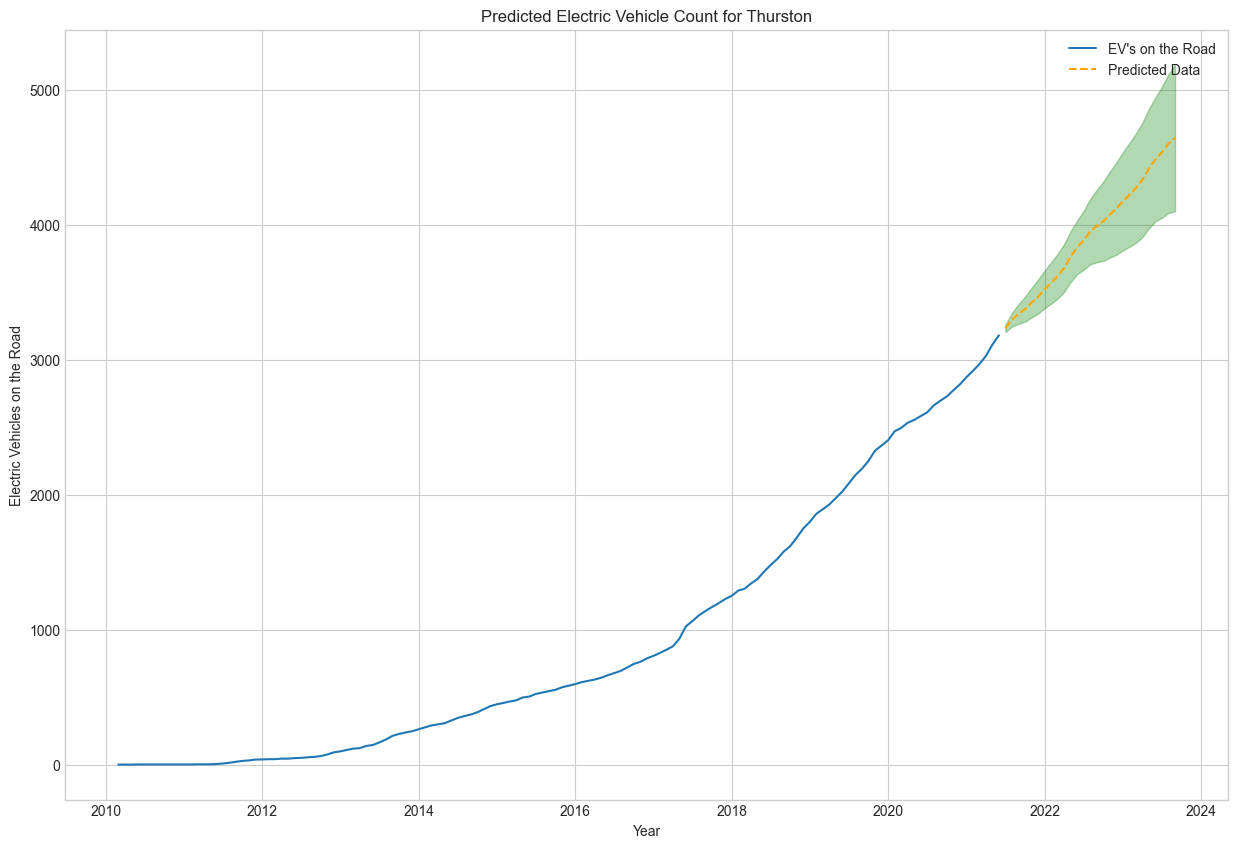

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Thurston_Prediction.csv'
Seasonality Check for :- Kitsap


<Figure size 1200x1000 with 0 Axes>

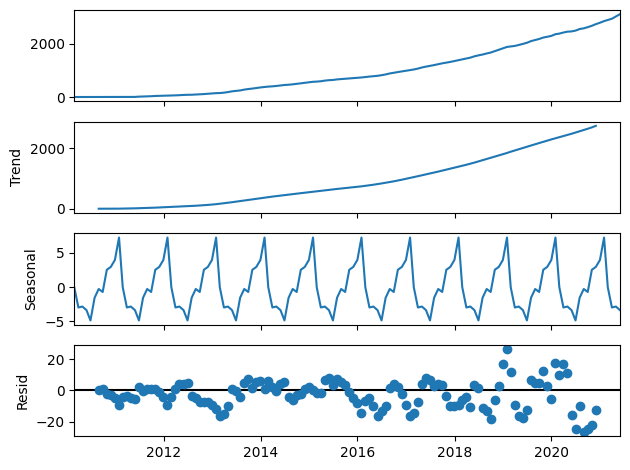

splitting dataset into train and test sets for validation 

plotting the split :- Kitsap


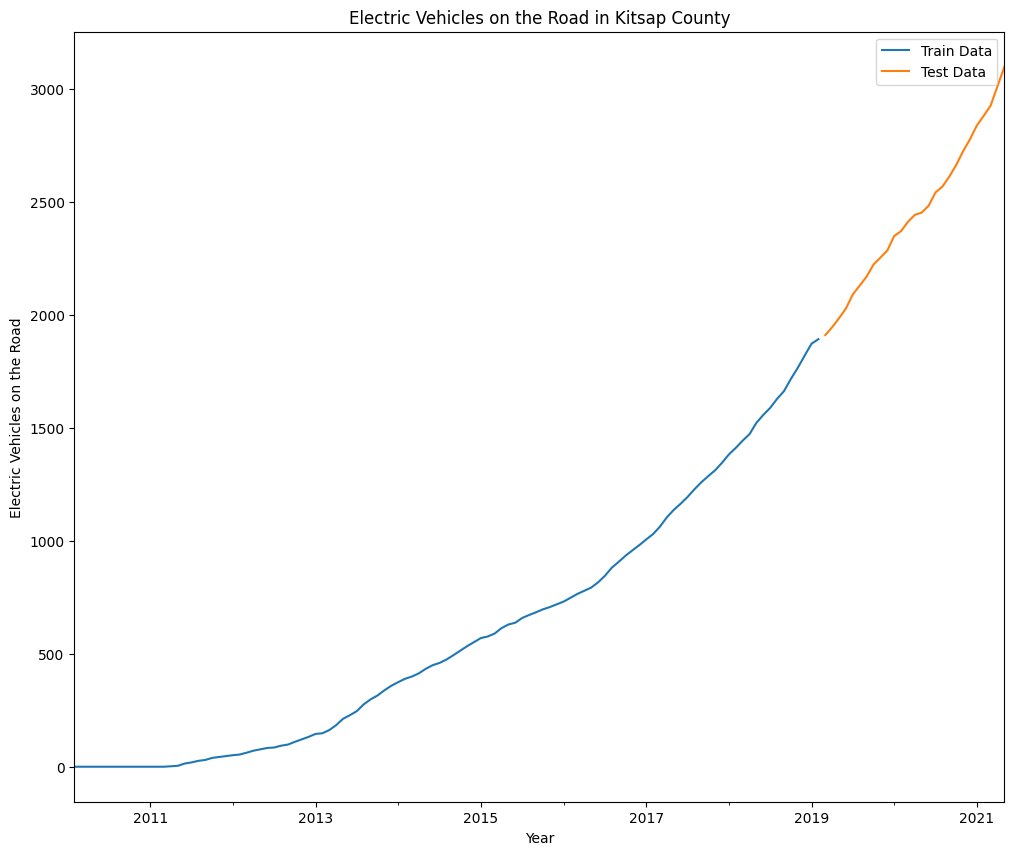

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Kitsap 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -331.355
Date:                            Mon, 03 Jul 2023   AIC                            666.710
Time:                                    18:12:33   BIC                            671.818
Sample:                                02-28-2010   HQIC                           668.774
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6489      0.083      7.843      0.000       0.487       0.811
sigma2        62.6787      7.462      8.400      0.000      48.054      77.304
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):                 5.36
Prob(Q):                              0.33   Prob(JB):                         0.07
Heteroskedasticity (H):               2.97   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

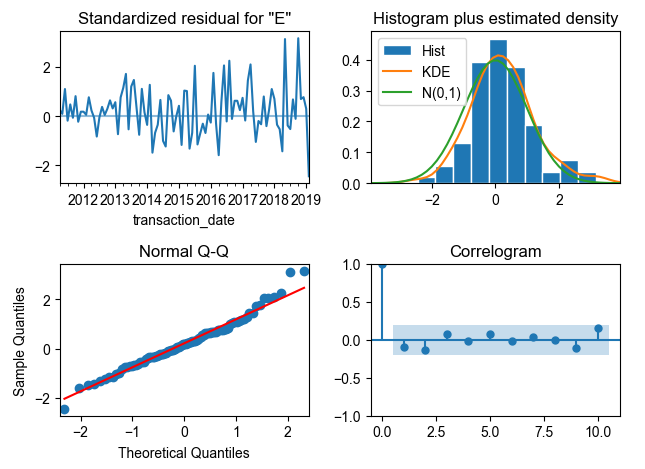

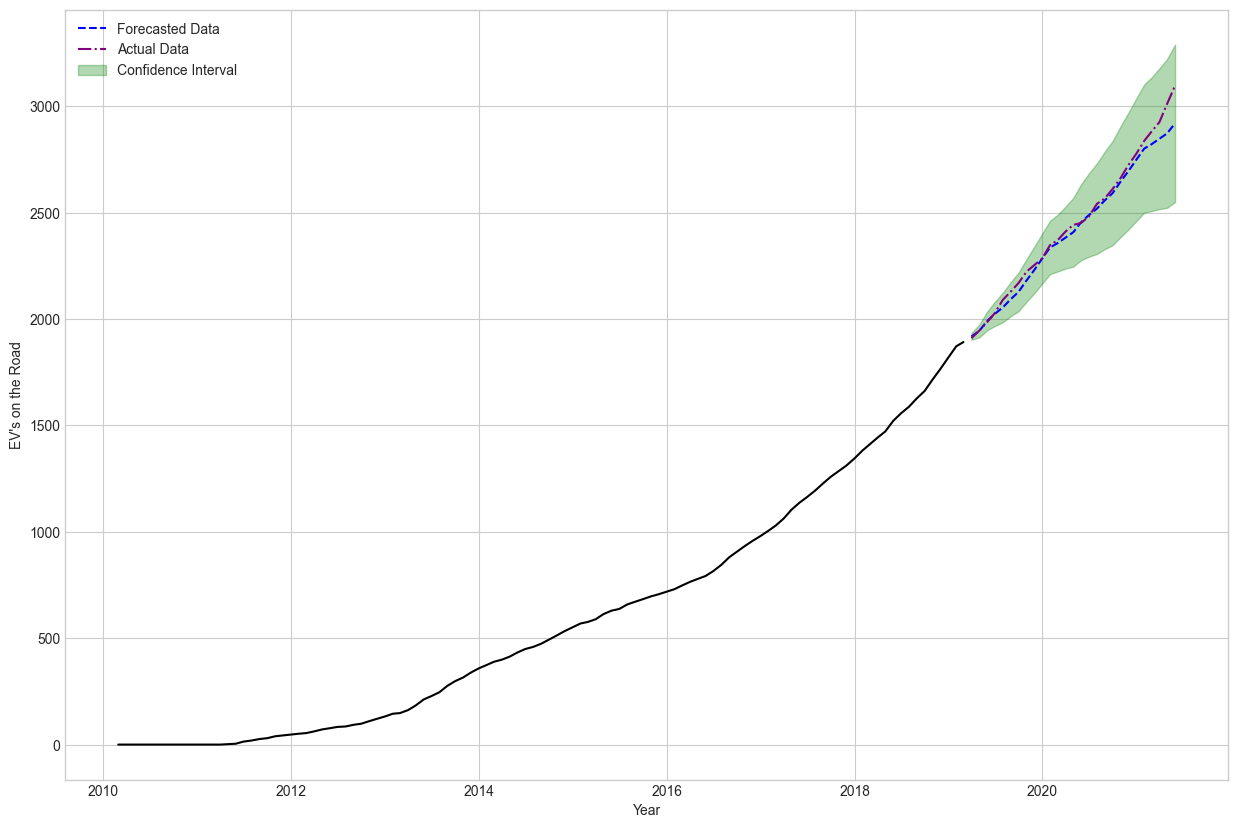

Future Predictions 

evaluate_model with Forecasts for Test Data Kitsap 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -474.913
Date:                            Mon, 03 Jul 2023   AIC                            953.827
Time:                                    18:12:34   BIC                            959.435
Sample:                                02-28-2010   HQIC                           956.104
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6392      0.056     11.341      0.000       0.529       0.750
sigma2       140.8346     11.698     12.039      0.000     117.907     163.763
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                61.76
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               8.90   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



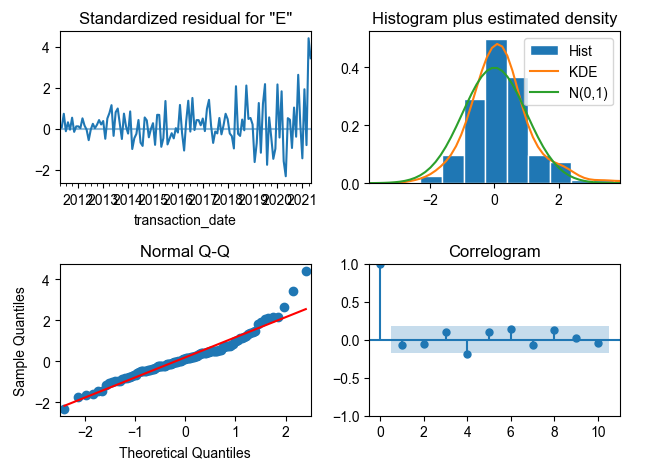

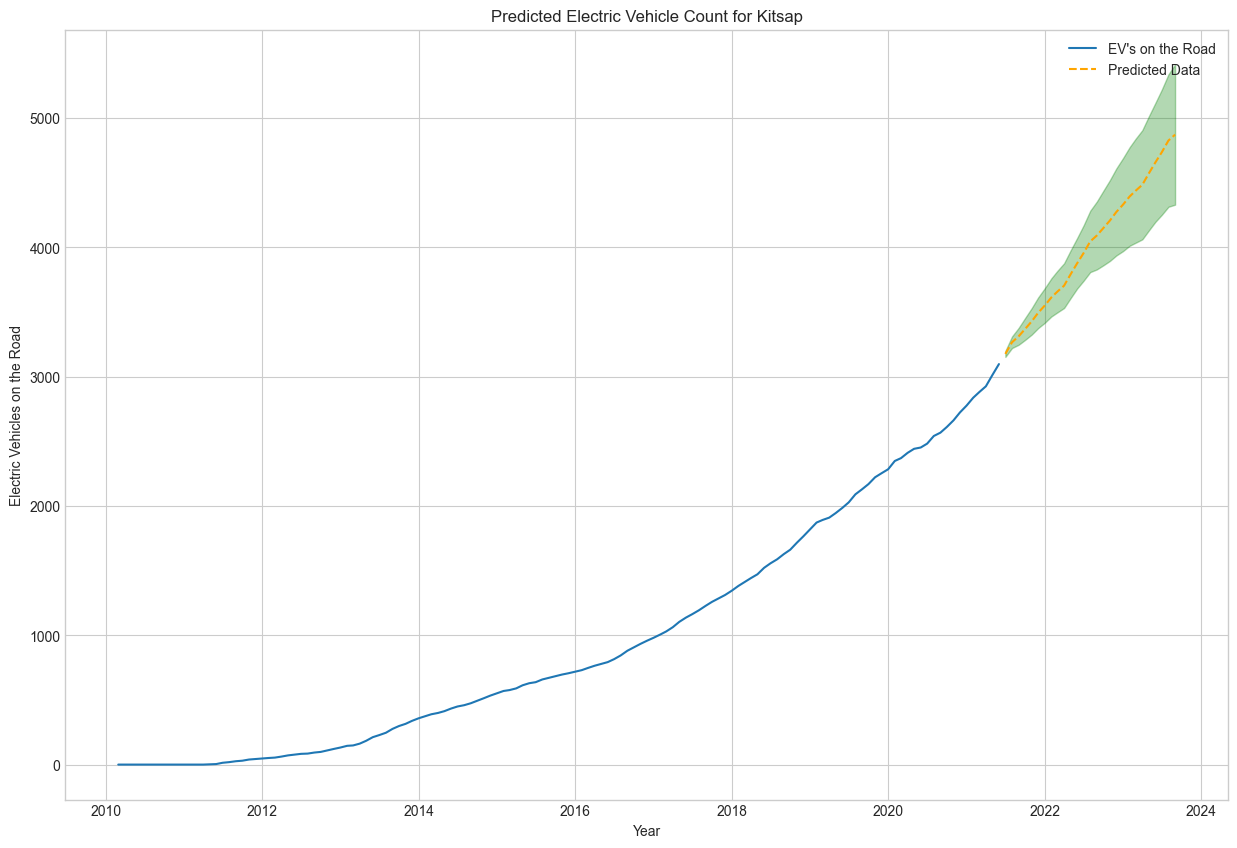

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Kitsap_Prediction.csv'
Seasonality Check for :- Whatcom


<Figure size 1200x1000 with 0 Axes>

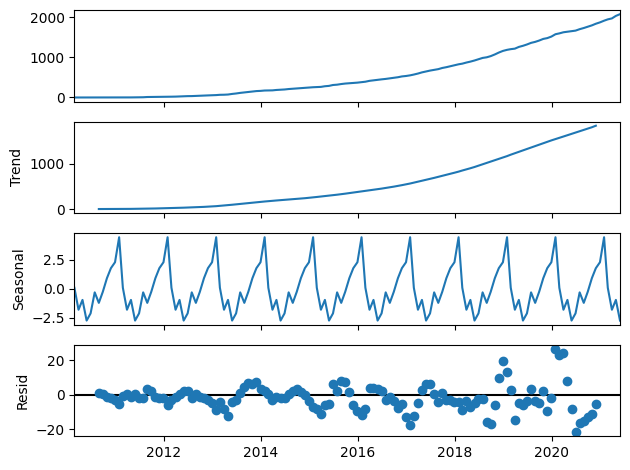

splitting dataset into train and test sets for validation 

plotting the split :- Whatcom


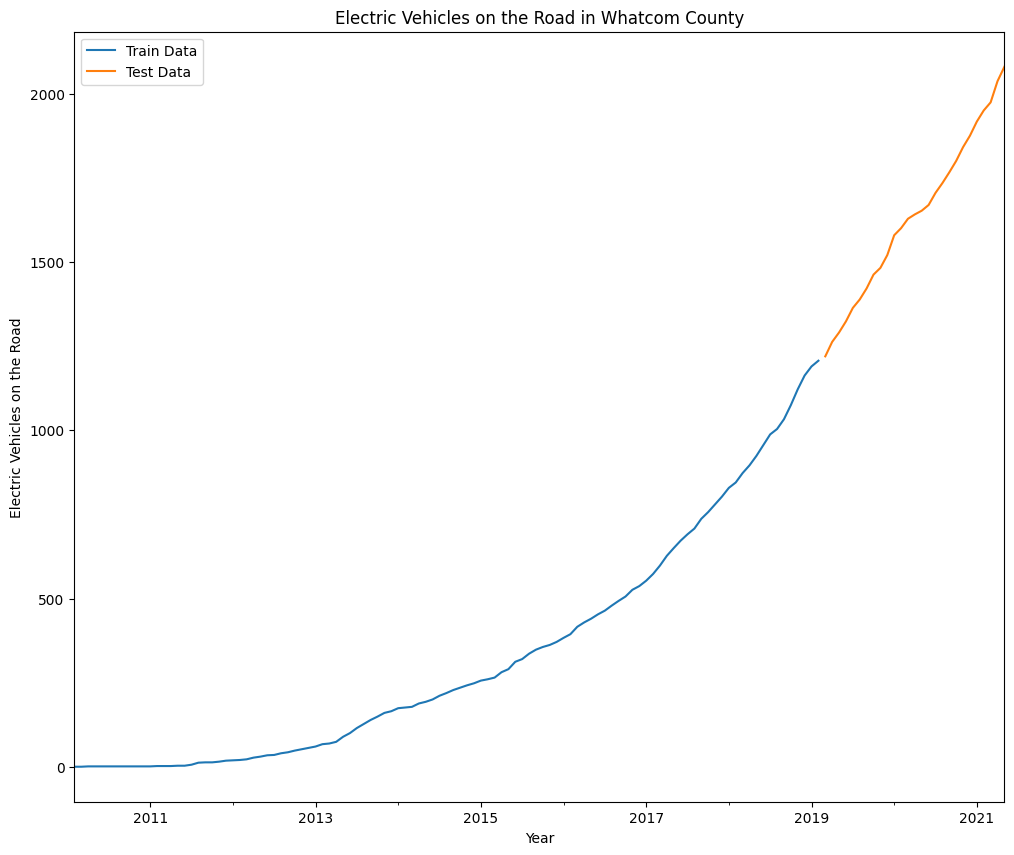

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Whatcom 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -308.230
Date:                            Mon, 03 Jul 2023   AIC                            620.461
Time:                                    18:12:49   BIC                            625.568
Sample:                                02-28-2010   HQIC                           622.525
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5237      0.075      7.019      0.000       0.377       0.670
sigma2        38.5202      4.451      8.654      0.000      29.796      47.245
===================================================================================
Ljung-Box (L1) (Q):                   4.92   Jarque-Bera (JB):                 5.72
Prob(Q):                              0.03   Prob(JB):                         0.06
Heteroskedasticity (H):               4.51   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

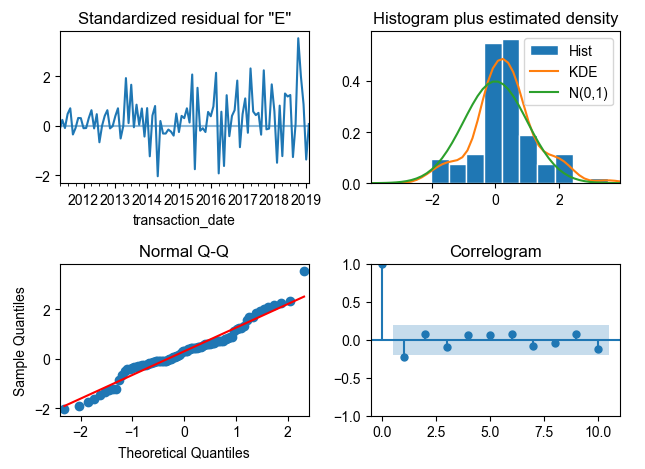

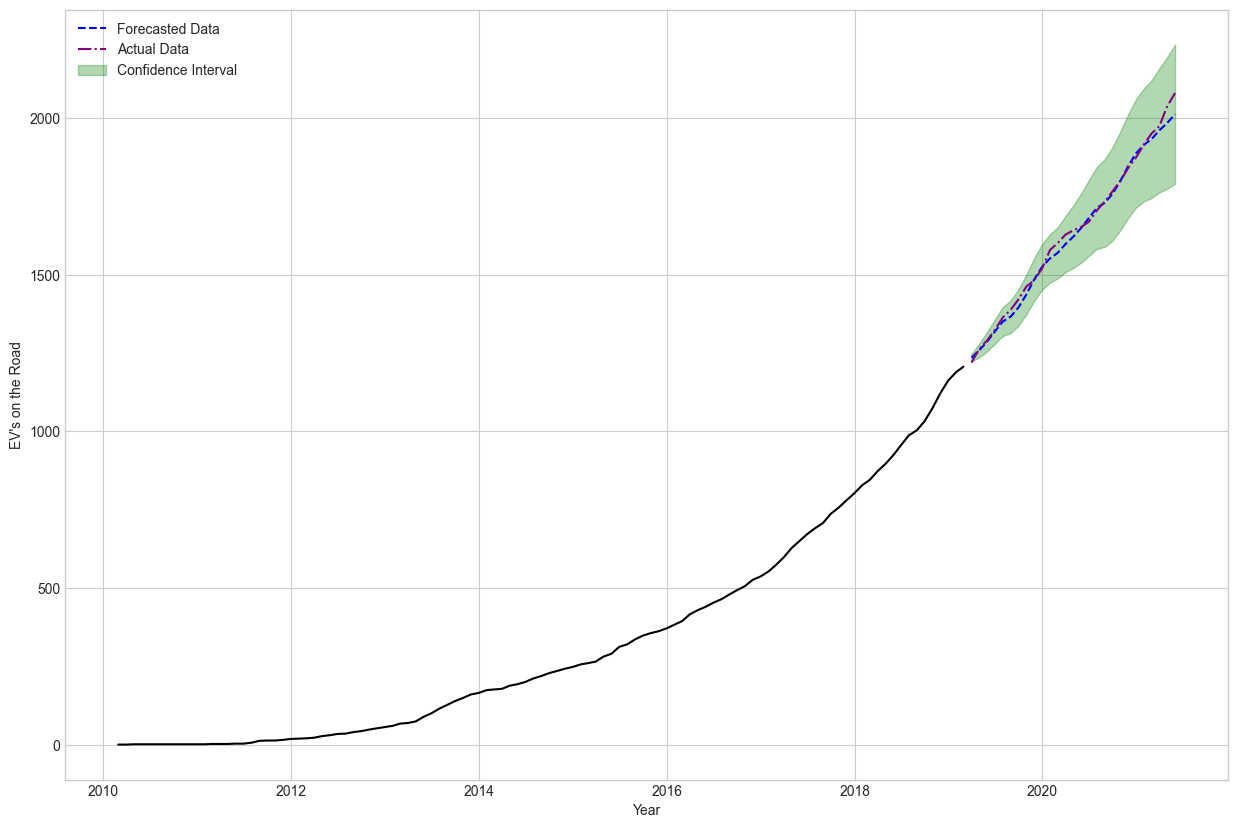

Future Predictions 

evaluate_model with Forecasts for Test Data Whatcom 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -455.671
Date:                            Mon, 03 Jul 2023   AIC                            915.342
Time:                                    18:12:50   BIC                            920.950
Sample:                                02-28-2010   HQIC                           917.620
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3137      0.080      3.942      0.000       0.158       0.470
sigma2       102.7339      6.808     15.091      0.000      89.391     116.077
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               204.79
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):              12.78   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



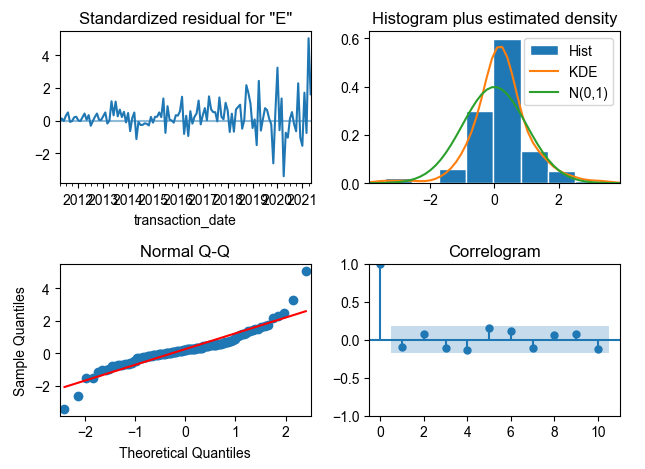

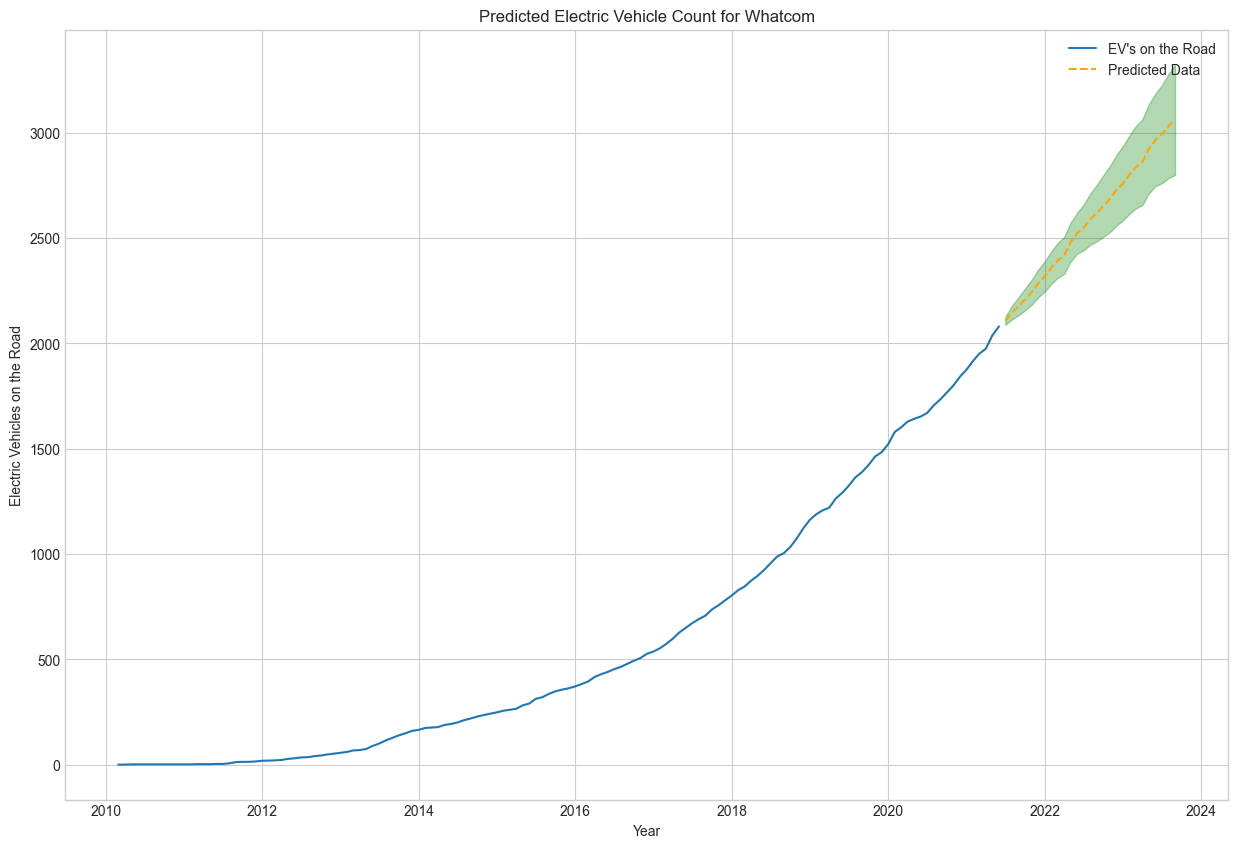

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Whatcom_Prediction.csv'
Seasonality Check for :- Spokane


<Figure size 1200x1000 with 0 Axes>

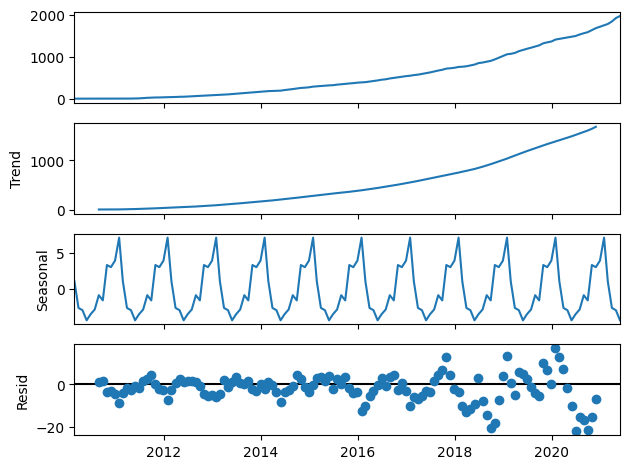

splitting dataset into train and test sets for validation 

plotting the split :- Spokane


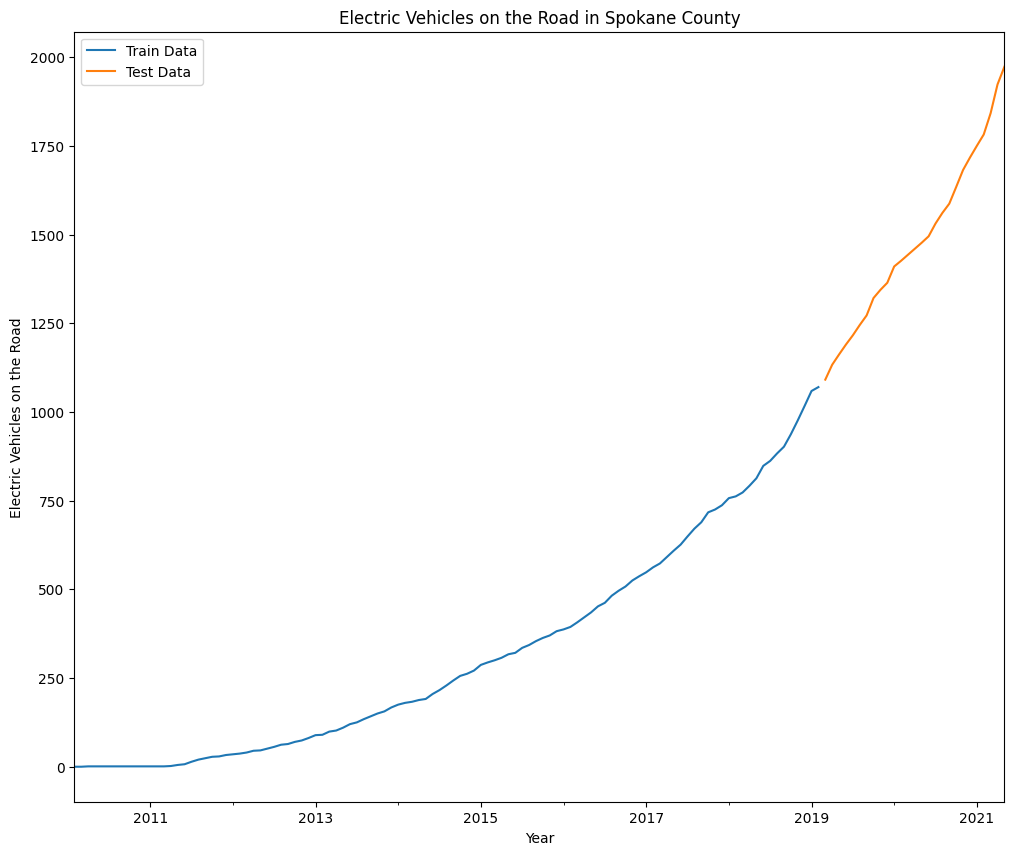

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Spokane 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -318.193
Date:                            Mon, 03 Jul 2023   AIC                            640.385
Time:                                    18:12:57   BIC                            645.493
Sample:                                02-28-2010   HQIC                           642.449
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3726      0.061      6.080      0.000       0.252       0.493
sigma2        47.5087      4.720     10.066      0.000      38.259      56.759
===================================================================================
Ljung-Box (L1) (Q):                   3.99   Jarque-Bera (JB):                31.24
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               9.04   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

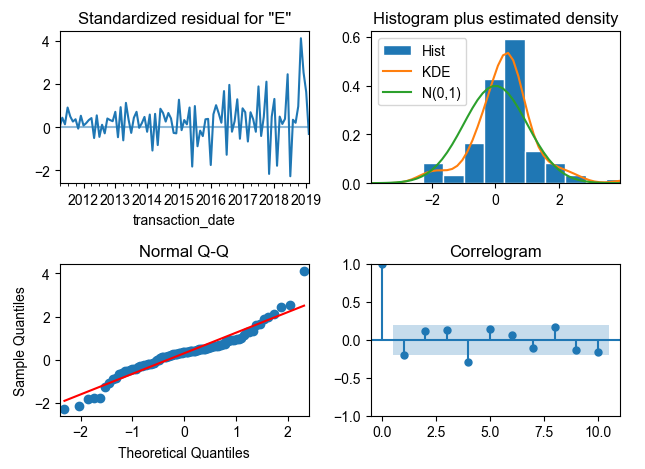

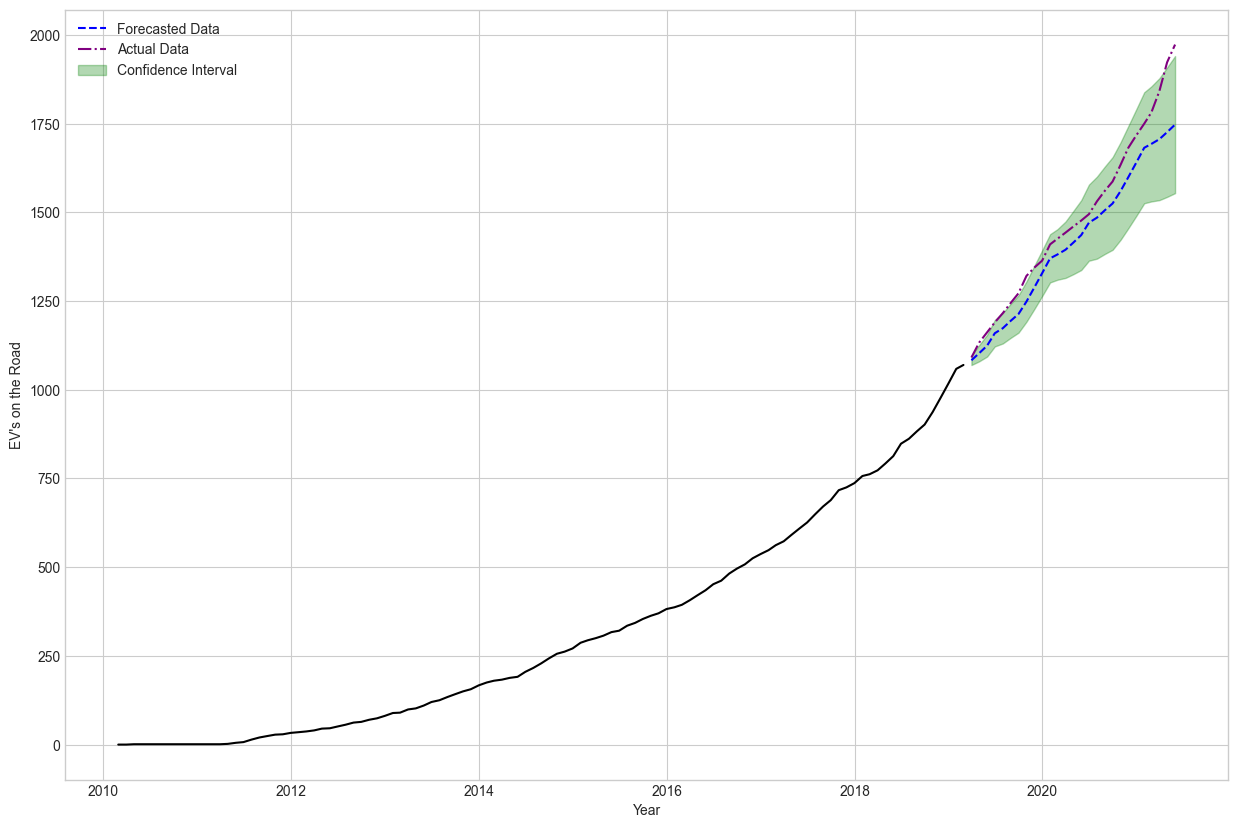

Future Predictions 

evaluate_model with Forecasts for Test Data Spokane 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -452.075
Date:                            Mon, 03 Jul 2023   AIC                            908.151
Time:                                    18:12:58   BIC                            913.759
Sample:                                02-28-2010   HQIC                           910.429
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5506      0.055      9.941      0.000       0.442       0.659
sigma2        96.8531      9.274     10.443      0.000      78.676     115.030
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                51.03
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              15.68   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



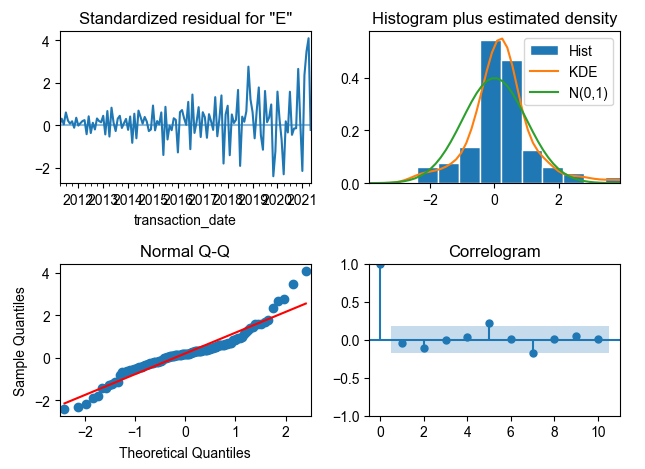

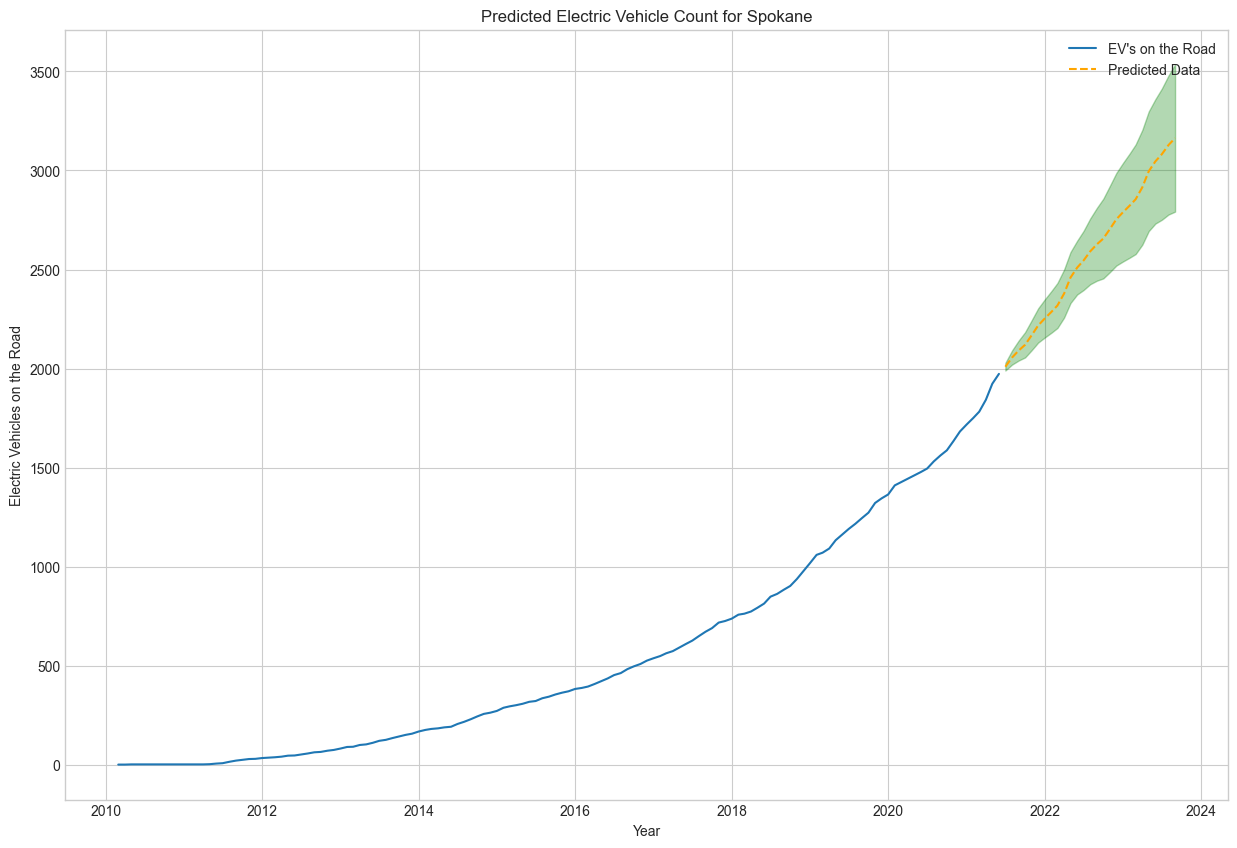

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Spokane_Prediction.csv'
Seasonality Check for :- Benton


<Figure size 1200x1000 with 0 Axes>

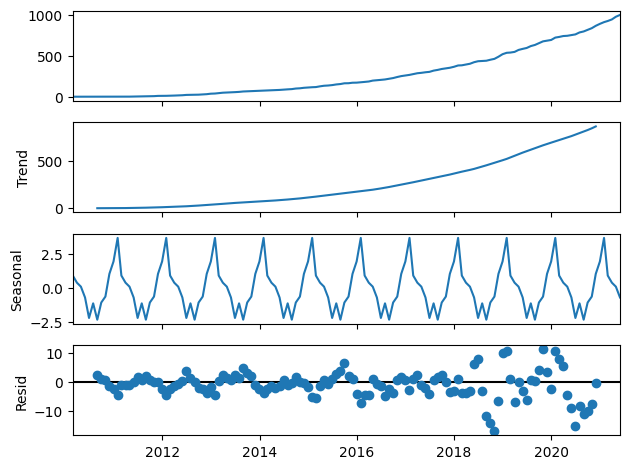

splitting dataset into train and test sets for validation 

plotting the split :- Benton


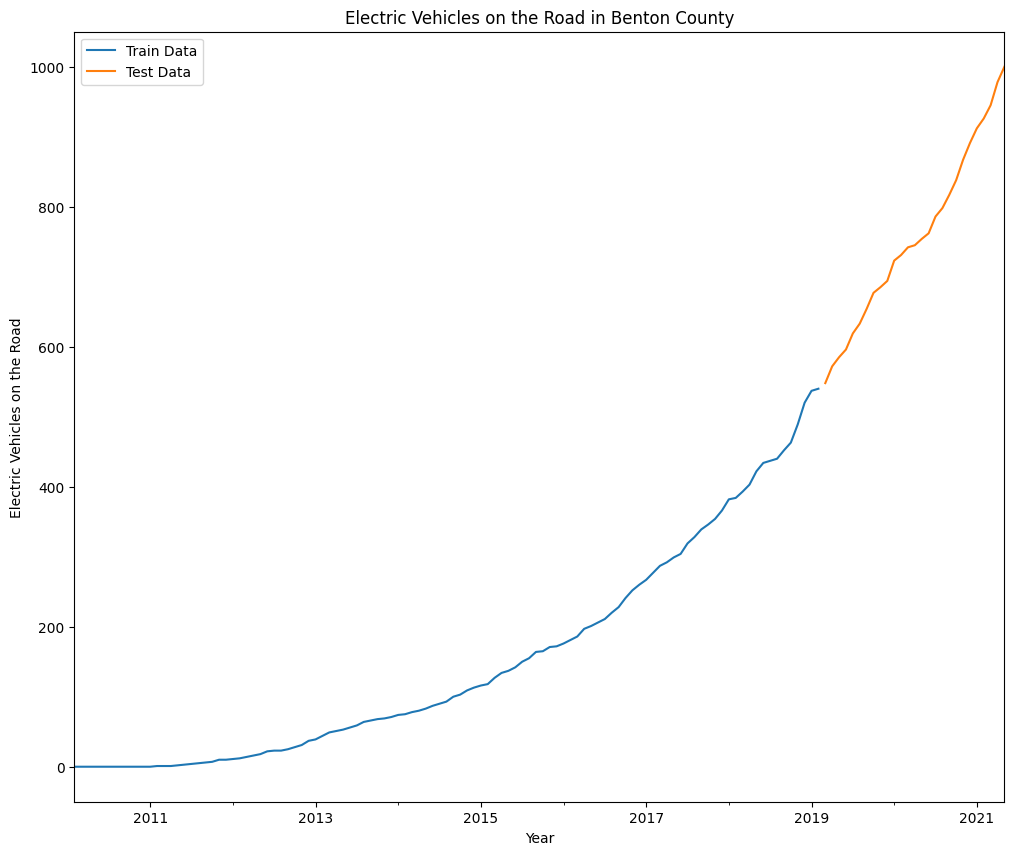

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Benton 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -277.805
Date:                            Mon, 03 Jul 2023   AIC                            559.610
Time:                                    18:13:01   BIC                            564.717
Sample:                                02-28-2010   HQIC                           561.673
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3230      0.064      5.035      0.000       0.197       0.449
sigma2        20.3005      1.921     10.569      0.000      16.536      24.065
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                37.18
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              13.18   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

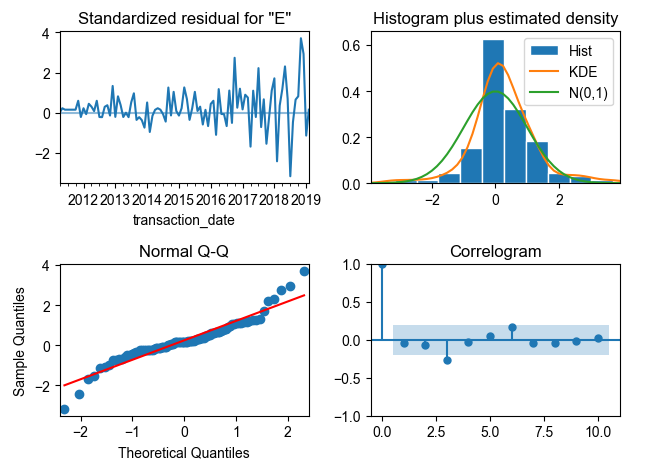

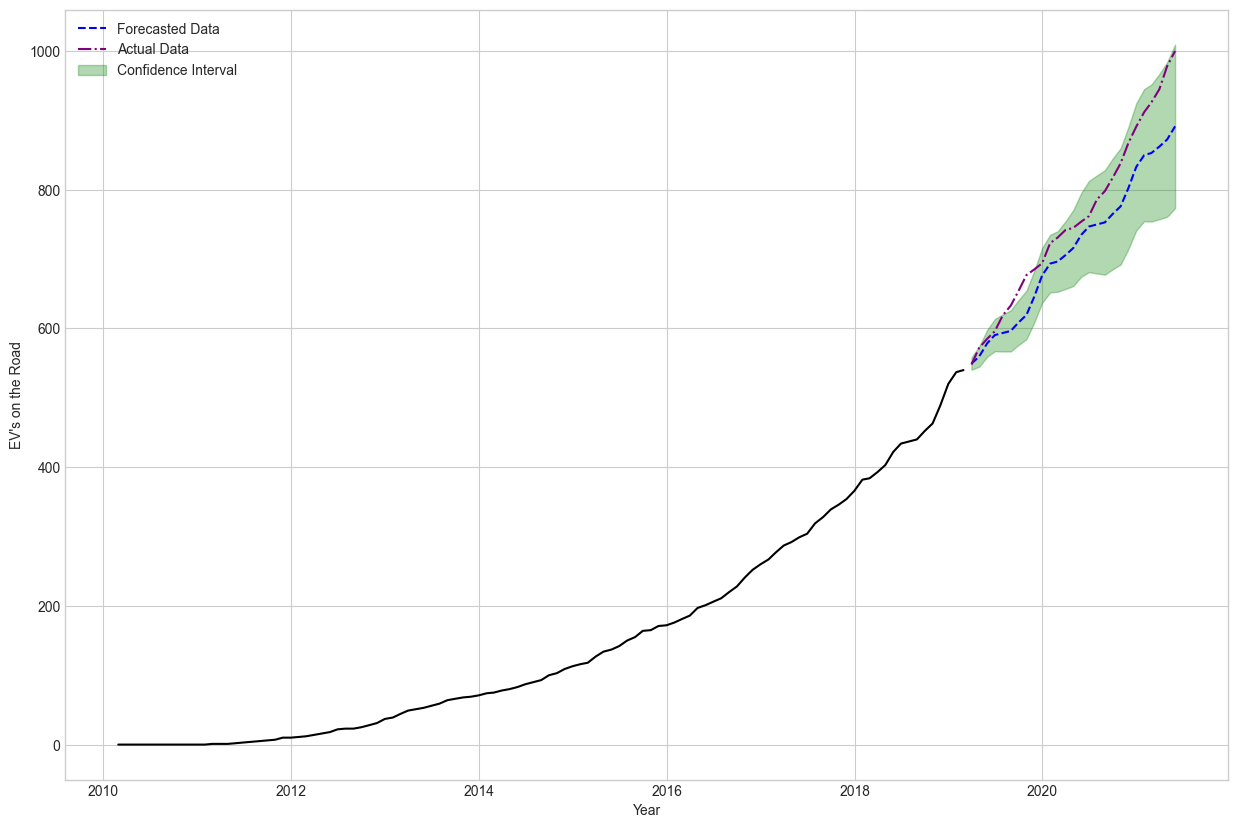

Future Predictions 

evaluate_model with Forecasts for Test Data Benton 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -410.472
Date:                            Mon, 03 Jul 2023   AIC                            824.944
Time:                                    18:13:02   BIC                            830.552
Sample:                                02-28-2010   HQIC                           827.222
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2875      0.062      4.620      0.000       0.166       0.409
sigma2        48.9682      3.739     13.098      0.000      41.640      56.296
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                74.88
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              31.69   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



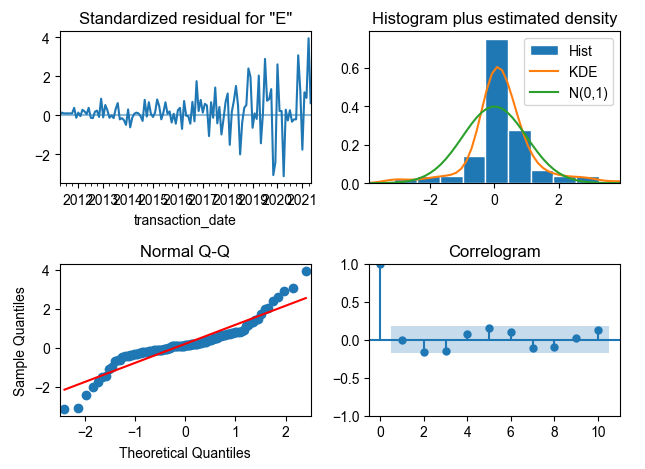

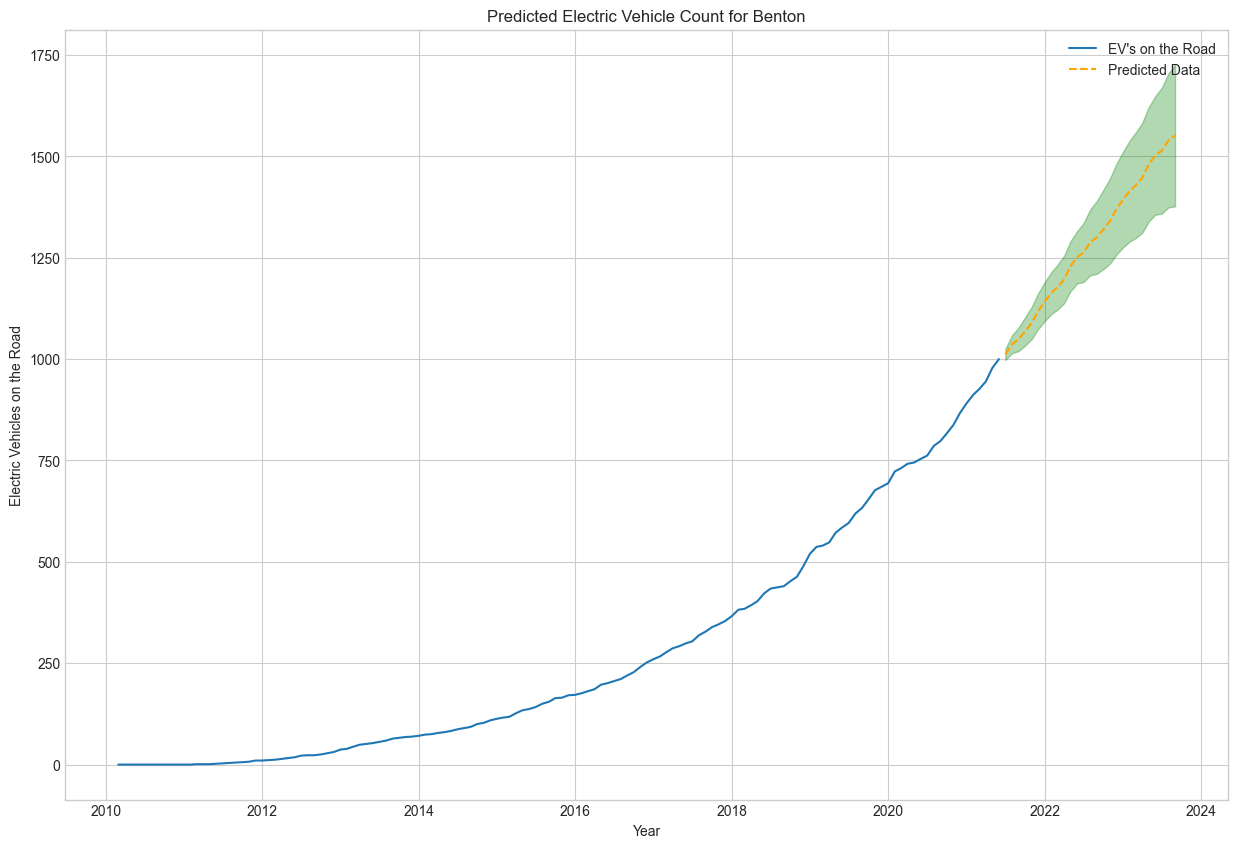

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Benton_Prediction.csv'
Seasonality Check for :- Island


<Figure size 1200x1000 with 0 Axes>

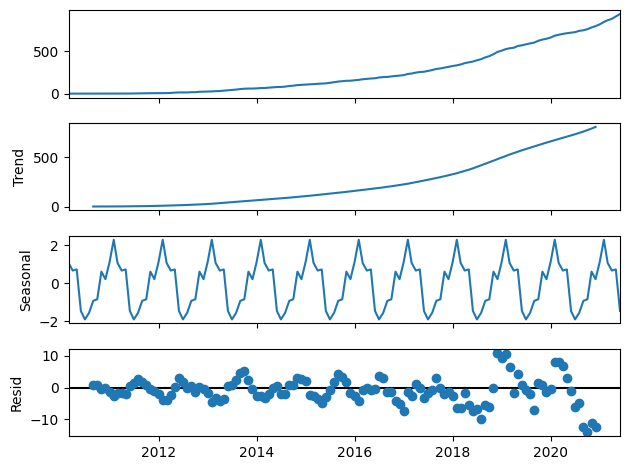

splitting dataset into train and test sets for validation 

plotting the split :- Island


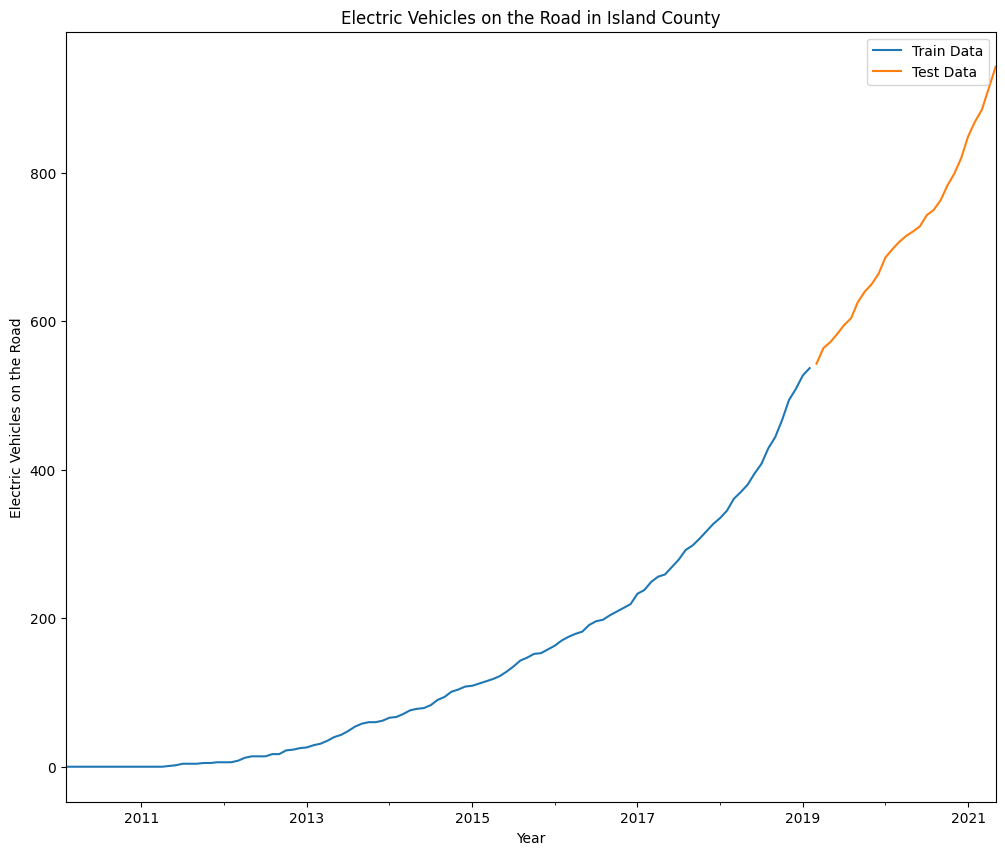

Finding Best Parameters with Auto-Arima 

Validate Model with Forecasts for Test Data 

evaluate_model with Forecasts for Test Data Island 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -256.863
Date:                            Mon, 03 Jul 2023   AIC                            517.727
Time:                                    18:13:21   BIC                            522.834
Sample:                                02-28-2010   HQIC                           519.791
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5042      0.060      8.453      0.000       0.387       0.621
sigma2        13.0628      1.751      7.459      0.000       9.630      16.495
===================================================================================
Ljung-Box (L1) (Q):                   6.73   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.01   Prob(JB):                         0.46
Heteroskedasticity (H):               7.55   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

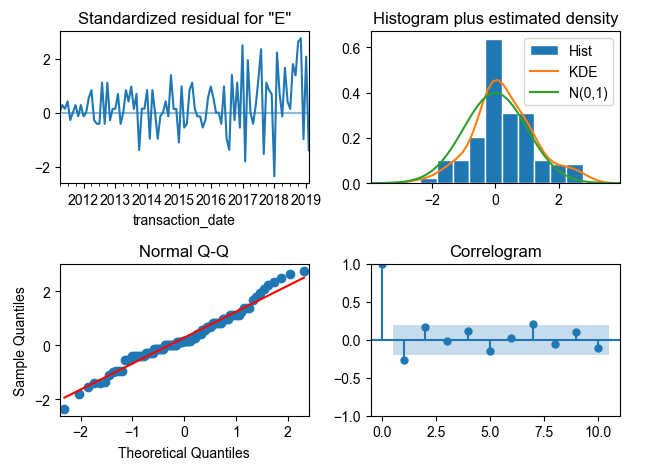

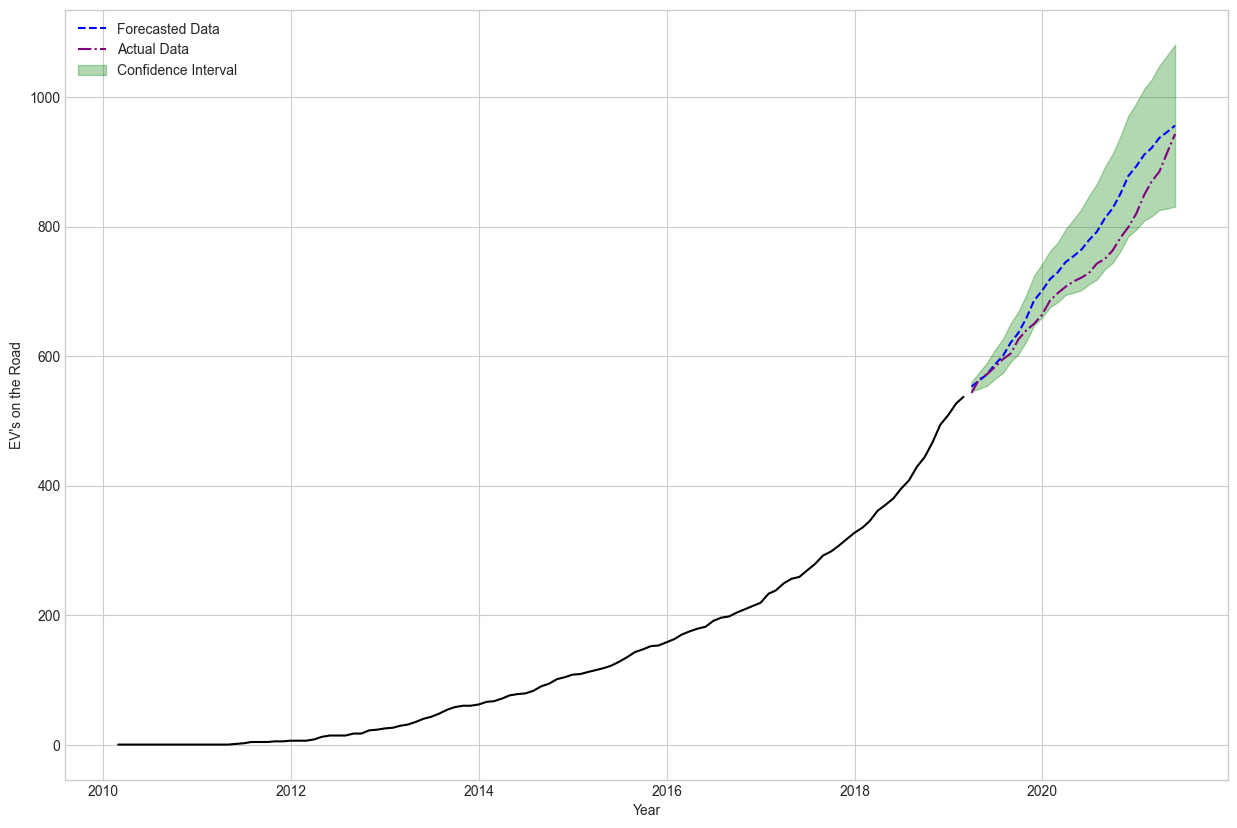

Future Predictions 

evaluate_model with Forecasts for Test Data Island 



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -376.210
Date:                            Mon, 03 Jul 2023   AIC                            756.420
Time:                                    18:13:22   BIC                            762.028
Sample:                                02-28-2010   HQIC                           758.697
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4317      0.055      7.800      0.000       0.323       0.540
sigma2        27.9243      2.614     10.684      0.000      22.802      33.047
===================================================================================
Ljung-Box (L1) (Q):                   2.20   Jarque-Bera (JB):                19.21
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              16.31   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

creating a df of predictions and plotting 



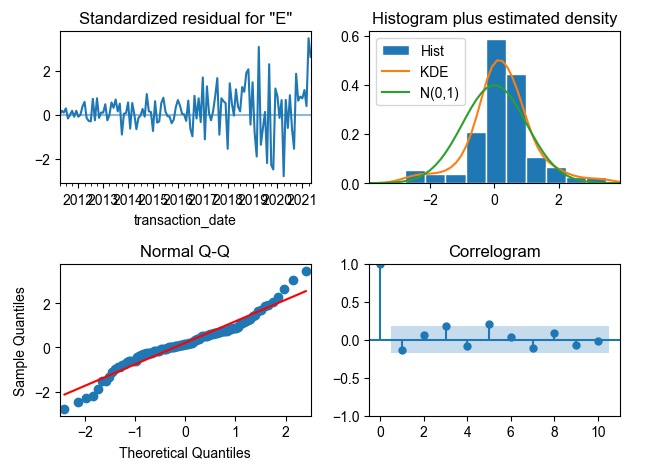

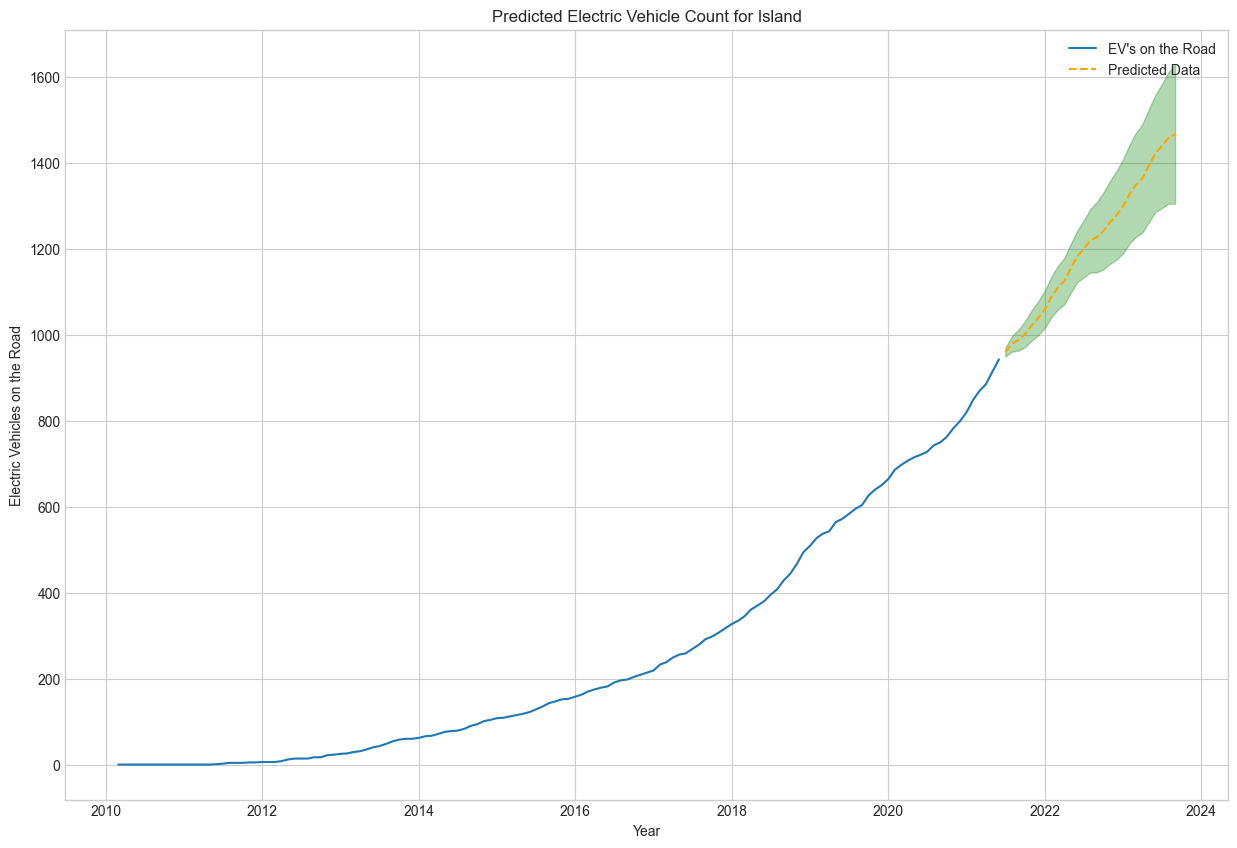

saving predictions df to dict for later use 

Output DataFrame saved to 'C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions\Island_Prediction.csv'


In [17]:
# Model Run


for county in county_information.keys():

    #Seasonality Check
    print('Seasonality Check for :-', county)
    plt.figure(figsize=(12, 10))
    decomp = tsa.seasonal_decompose(county_information[county]['df'])
    decomp.plot()
    plt.show()

    #splitting dataset into train and test sets for validation
    print('splitting dataset into train and test sets for validation \n')

    train_var = 'train_' + county
    test_var = 'test_' + county

    locals()[train_var], locals()[test_var] = train_test_split_ts(county_information[county]['df'], 0.80, 0.20)

    #plotting the split
    print('plotting the split :-', county)
    plt.figure(figsize=(12, 10))
    plot_train_test_split(locals()[train_var], locals()[test_var], county)
    plt.show()

    # Finding Best Parameters with Auto-Arima
    print('Finding Best Parameters with Auto-Arima \n')
    auto_model = pm.auto_arima(locals()[train_var], start_p=0, d=1, start_q=0, max_p=4, 
                            max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3, 
                            max_D=3, max_Q=3, m=12)
    auto_model.summary()

    # Validate Model with Forecasts for Test Data
    print('Validate Model with Forecasts for Test Data \n')
    model = SARIMAX(locals()[train_var], order=(1,1,0), 
                    seasonal_order=(0,1,0,12), enforce_invertibility=False, 
                    enforce_stationarity=False).fit()
    evaluate_model(model, county)

    df_forecast_var = 'df_' + county + '_forecast'

    locals()[df_forecast_var] = get_forecast(model, locals()[train_var], locals()[test_var], plot=True)

    # Future Predictions
    print('Future Predictions \n')
    # Fitting Model to All Observed Data
    model = SARIMAX(county_information[county]['df'], order=(1,1,0), 
                    seasonal_order=(0,1,0,12), enforce_invertibility=False, 
                    enforce_stationarity=False).fit()
    evaluate_model(model, county)

    #creating a df of predictions and plotting
    print('creating a df of predictions and plotting \n')

    df_preds_var = 'df_' + county + '_forecast'

    locals()[df_preds_var] = get_prediction(model, county_information[county]['df'], 
                                locals()[test_var], county, plot=True)

    #saving predictions df to dict for later use
    print('saving predictions df to dict for later use \n')
    county_information[county]['Predictions'] = locals()[df_preds_var]
    
    
    #`county_information` is a dictionary containing county information

    df = round(county_information[county]['Predictions'], 0)
    folder_path = r"C:\Users\pmoff\OneDrive\Desktop\PWSkills\MLProjects\EV_E_Mobility\.2_Electric_Vehicles_and_Chargers_in_Washington_State\Output_files\Chargers_predictions"
    # Create the directory if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    output_file_name = county + "_Prediction.csv"
    output_file_path = os.path.join(folder_path, output_file_name)
    # Save the output DataFrame to CSV
    df.to_csv(output_file_path, index=False)
    # Confirmation message
    print(f"Output DataFrame saved to '{output_file_path}'")
        